In [2]:
from glob import glob
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import scipy
import sklearn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import seaborn as sns
import time
import operator
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,fbeta_score,make_scorer,mutual_info_score,silhouette_score,normalized_mutual_info_score,classification_report, confusion_matrix,f1_score, mean_squared_error, adjusted_mutual_info_score, adjusted_rand_score
import time 
from sklearn.model_selection import LearningCurveDisplay
import tensorflow_addons as tfa
from NNnet_class import NNnet
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA,FastICA
from sklearn.random_projection import johnson_lindenstrauss_min_dim,SparseRandomProjection,GaussianRandomProjection
from sklearn.manifold import TSNE, Isomap
from A3_utils import calculate_wcss,plot_gallery,create_elbow_plot
from kmodes.kmodes import KModes
import umap

c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you w

In [3]:
#Seeting seed
np.random.seed(42)

#Making accuracy scorrer
accuracy_scorer=make_scorer(accuracy_score)

#Global Beta (Used for Ftwo score - not used in assignment)
BETA=2

In [4]:
def create_param_curve(data,param,param_vals,ax,algorithim_name,algorithim,metric=accuracy_scorer,metric_name='Accuracy',graph=True,beta=BETA,cv=3):

    '''Function to create parameter curves
    
    Parameters:
    data (list): List of np.arrays containing the features and labels  
    param (str): Parameter to vary
    param_vals (list): Parameter values
    ax (matplotlib.axes): Axis for graph
    algorithim (sklearn.algorithim/NNnet): Algorithim to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    graph (bool): Bool for validation graph
    beta (int): Beta value for the Ftwo scored 
    cv (int): The number of cross validations folds
    
    Returns:
    None'''


    train_acc=[]
    test_acc=[]
    
    for i in param_vals:
        #Crossvalidating each parameter value
        kf=KFold(n_splits=cv,shuffle=True)

        internal_train_accuracy=0
        internal_test_accuracy=0
        
        for train,test in kf.split(X=data[0]):
            if i!='Default':
                if 'net' in algorithim_name.lower():
                    kwargs={param:i,'input_dims':data[0].shape[-1]}
                    clf=algorithim(**kwargs)
                else:
                    clf=algorithim(**{param:i})
            else:
                clf=algorithim()

            clf.fit(data[0][train],data[1][train])
            internal_train_accuracy+=metric(y_pred=clf.predict(data[0][train]),y_true=data[1][train])
            internal_test_accuracy+=metric(y_pred=clf.predict(data[0][test]),y_true=data[1][test])

        train_acc.append(internal_train_accuracy/cv)
        test_acc.append(internal_test_accuracy/cv)

    best_val=param_vals[np.argmax(test_acc)]

    if type(param_vals[0])==str:
        ax.scatter(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.scatter(param_vals,test_acc,label='Validation {}'.format(metric_name))
    else:
        ax.plot(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.plot(param_vals,test_acc,label='Validation {}'.format(metric_name))
    #plt.xscale('log')
    ax.axvline(best_val,label='Best {} Value'.format(param),color='red',linestyle = '--')
    ax.legend()
    ax.set_ylabel('{}'.format(metric_name));
    ax.set_xlabel(param);
    ax.set_title('{} vs {}'.format(param,metric_name));
    if type(best_val)!=str:
        if best_val==max(param_vals):
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val-np.std(param_vals)/12,s=best_val,color='green',weight='bold')
        else:
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val+np.std(param_vals)/12,s=best_val,color='green',weight='bold')

In [5]:
def deal_algorithim(data,param_dicts,dataset,algorithim_name,algorithim,metric=accuracy_score,metric_name='Accuracy',cv=3):
    
    '''Function to deal with algorithim
    
    Parameters:
    data (list): List of np.arrays containing the features and labels
    param_dict (dict): Parameter dictionary to vary
    dataset (str): Dataset name
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim/NNnet): Algorithim to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    cv (int): The number of cross validations folds 

    Returns:
    None'''
    
    num_classes=len(param_dicts.keys())

    #Getting Fig Size
    fig,axes=plt.subplots(2,int(np.ceil(num_classes/2)))
    fig.set_size_inches(15,15)
    i=-1
    for c,ax in enumerate(fig.axes):
        i+=1
        plt.suptitle('Results for Algorithim: "{}" for "{}" Dataset'.format(algorithim_name,dataset),fontsize=18)
        param=list(param_dicts.keys())[i]
        param_vals=param_dicts[param]
        create_param_curve(data,param,param_vals,ax,algorithim_name,algorithim,metric,metric_name)
    plt.tight_layout()

In [6]:
#Load Heart Disease Data
def load_heart_data():

    '''Load Heart Disease Dataset
    
    Returns:
    X (np.array): X array
    Y (np.array): Y array
    col_index (dict): Dictionary containing the pairing for the column location and it's name'''

    #PLEASE CHANGE TO LOCATION OF YOUR HEART DATA
    df=pd.read_csv('Data/Heart_2/heart.csv')
    Y=np.array(df['HeartDisease'])
    df.drop('HeartDisease',axis=1,inplace=True)
    
    label_columns=['HeartDisease']
    categorical_columns=['Sex', 'ChestPainType', 'RestingECG','ExerciseAngina','ST_Slope','FastingBS']

    non_categorical_variables=list(set(df.columns).difference(set(categorical_columns+label_columns)))
    X=np.array(df[non_categorical_variables])
    columns_categorized=non_categorical_variables

    #Now we need to one hot vectorize the type_of_meal_plan, room_type_reserved and market_segment_type
    label_dict={}
    for i in categorical_columns:
        label_dict[i]=OneHotEncoder()
        res=label_dict[i].fit_transform(np.array(df[i]).reshape(-1,1)).toarray()
        X=np.c_[X,res]
        columns_categorized=columns_categorized+[i+'%'+j for j in ['1','2','3','4','5','6','7'][:res.shape[-1]]]

        col_index={}
        results_corr={}
        for label,col in zip(columns_categorized,range(X.shape[-1])):
            corr=scipy.stats.pearsonr(X[:,col],Y)[0]
            results_corr[label]=corr
            col_index[label]=col
    return X,Y,col_index

#Fashion MNIST
def load_fmnist():
    #Loading dataset
    data=pd.concat([pd.read_csv('Data/FMNIST/fashion-mnist_train.csv'),pd.read_csv('Data/FMNIST/fashion-mnist_test.csv')],axis=0)

    X=data.iloc[:,1:].to_numpy()
    Y=data.iloc[:,:1].to_numpy().ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,random_state=42,stratify=Y)

    return X_test,y_test


#Load Pokemon Data
def load_pokemon():
    directory='Data/Pokemon/'
    image_files = glob(os.path.join(directory, '**', '*.*'), recursive=True)

    # Initialize a list to store the images as NumPy arrays
    features=[]
    labels=[]

    # Iterate over the Image files
    for file in image_files:

        #Name of pokemon
        label=file.split('\\')[1]

        #Appending name
        labels.append(label)

        #Reading images
        image = Image.open(file)

        #Converting to RGB
        image = image.convert('RGB')

        #Removing color
        image=image.convert('L')
        
        #Resizing images
        image=image.resize((48, 48))

        #Appending images
        features.append(np.array(image).flatten())

    #Converting to Numpy
    labels=np.array(labels)
    features=np.array(features)

    pokemon_names=LabelEncoder()
    labels_encoded=pokemon_names.fit_transform(labels)

    return features,labels_encoded,pokemon_names

In [7]:
def score_algorithim(X,Y,dataset_name,algorithim_name,algorithim,params,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy',return_needed=False):

    '''Function to score algorithim
    
    Parameters:
    X (np.array): All features
    Y (np.array): All labels
    dataset_name (str): Dataset name
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim/NNnet): Algorithim being experimented on
    params (dict): Parameter dictionary for GridSearch
    predictor_metric (sklearn.metric): Metric to score algorotihim on
    grid_search_metric (sklearn.metric): Metric used by GridSearchCV
    predictor_metric_name (str): Metric Name for predictor metric
    return_needed (bool): Bool if fit model needed to be returned    

    Returns:
    glf (sklearn.model/NNnet): Fit model'''

    standardize=False
    if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
        standardize=True
    
    if 'NET' in algorithim_name.upper():
        n_jobs=1
    else:
        n_jobs=-1


    train,test=split_data(X,Y,valid=False,standardize=standardize)

    glf_cv=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric,refit=True)

    rep=10
    start_time=time.time()
    glf_cv.fit(train[0],train[1])

    glf=glf_cv.best_estimator_
    
    for i in range(rep):
        glf.fit(train[0],train[1])
    time_delay_train=(time.time()-start_time)/rep

    y_train_pred=glf.predict(train[0])
    
    if 'F' in predictor_metric_name.upper():
        train_score = predictor_metric(y_pred=glf.predict(train[0]),y_true=train[1],beta=BETA)
        test_score = predictor_metric(y_pred=glf.predict(test[0]),y_true=test[1],beta=BETA)
    else:
        train_score = predictor_metric(y_pred=glf.predict(train[0]),y_true=train[1])
        test_score = predictor_metric(y_pred=glf.predict(test[0]),y_true=test[1])

    start_time=time.time()
    for i in range(rep):
        y_test_pred=glf.predict(test[0])
    time_delay_infer=(time.time()-start_time)/rep

    print('{} Final Results'.format(dataset_name))
    print('\n')
    print(glf_cv.best_params_)
    print('\n')
    print('Average time to train the ideal {} was {:.3f} seconds'.format(algorithim_name,time_delay_train))
    print('Average time to infer the ideal {} was {:.3f} seconds'.format(algorithim_name,time_delay_infer))
    print('\n')
    print('The result on the training data for the ideal {} algorithim is a {} {} score'.format(algorithim_name,train_score,predictor_metric_name))
    print('The result on the test data for the ideal {} algorithim is a {} {} score'.format(algorithim_name,test_score,predictor_metric_name))
    
    if return_needed:
        return glf

In [8]:
def split_data(X,Y,valid=True,standardize=False):

    '''
    Split the data between train, test and optional validation dataset

    Parameters:
    X (np.array): X features
    Y (np.rray): Labels
    valid (bool): Split into validation dataset 
    standardize (bool): Whether to standardize the data (introduces bias as Sklearn Standard Scaler is trained only on the train data)

    Returns:
    train (list): np.array list of train
    valid (list): optional np.array list of validation
    test (list): np.array list of test
    '''
    
    #Now let's split the data between test and train, we'll use the standard 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
    
    if valid:
        #We'll also split the data between train and validation, we'll again use the standard 80/20 split
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2,random_state=42)
        
        if standardize:
            sklr=StandardScaler()
            X_train=sklr.fit_transform(X_train)
            X_valid=sklr.transform(X_valid)
            X_test=sklr.transform(X_test)
        return [X_train,y_train],[X_valid,y_valid],[X_test,y_test]

    if standardize:
        sklr=StandardScaler()
        X_train=sklr.fit_transform(X_train)
        X_test=sklr.transform(X_test)
    return [X_train,y_train],[X_test,y_test]

In [9]:
#Pokemon
X_poke,Y_poke,poke_encoder=load_pokemon()
train_poke,test_poke=split_data(X_poke,Y_poke,valid=False)

#Heart
X_heart,Y_heart,heart_index=load_heart_data()
train_heart,test_heart=split_data(X_heart,Y_heart,valid=False)

#Fashion MNIST
X_fm,Y_fm=load_fmnist()
train_fm,test_fm=split_data(X_fm,Y_fm,valid=False)

In [10]:
#Standardizing
sklr_poke=StandardScaler()
sklr_heart=StandardScaler()
sklr_fm=StandardScaler()

X_poke_scaler=StandardScaler()
X_heart_scaler=StandardScaler()
X_fm_scaler=StandardScaler()

#poke
X_poke_scaled=X_poke_scaler.fit_transform(X_poke)

train_poke_standardized=train_poke.copy()
train_poke_unstandardized=test_poke.copy()

test_poke_standardized=test_poke.copy()

train_poke_standardized[0]=sklr_poke.fit_transform(train_poke[0])
test_poke_standardized[0]=sklr_poke.transform(test_poke[0])

#Heart
X_heart_scaled=X_heart_scaler.fit_transform(X_heart)

train_heart_standardized=train_heart.copy()

test_heart_standardized=test_heart.copy()

train_heart_standardized[0]=sklr_heart.fit_transform(train_heart[0])
test_heart_standardized[0]=sklr_heart.transform(test_heart[0])

#FMNIST
X_fm_scaled=X_fm_scaler.fit_transform(X_fm)

train_fm_standardized=train_fm.copy()
train_fm_unstandardized=test_fm.copy()

test_fm_standardized=test_fm.copy()

train_fm_standardized[0]=sklr_fm.fit_transform(train_fm[0])
test_fm_standardized[0]=sklr_fm.transform(test_fm[0])

#### TESTING

In [117]:
#Best Number of Clusters
best_clusters_d1=8

#Best EM model
best_em_d1=GaussianMixture(n_components=best_clusters_d1,random_state=63)
best_em_d1.fit(X_fm_scaled)

#Adjusted NMI
adjusted_mutual_info_score(Y_fm,best_em_d1.predict(X_fm_scaled))

0.5118409541557777

In [118]:
dataset=X_heart_scaled
labels_og=Y_heart

In [120]:
#Selecting the best number of cluster and plotting pair plots

#Best Number of Clusters
best_clusters_d2=9

#Best EM model
best_em_d2=GaussianMixture(n_components=best_clusters_d2,random_state=63)

# #Getting labels for best cluster
# labels=best_em.predict(X_heart_scaled)



#Adjusted NMI
best_em_d2.fit(X_heart_scaled)
labels=best_em_d2.predict(X_heart_scaled)
print(adjusted_mutual_info_score(Y_heart,best_em_d2.predict(X_heart_scaled)))

#ARI
print(adjusted_rand_score(Y_heart,best_em_d2.predict(X_heart_scaled)))



0.09685478175764285
0.052247776262521764


<Figure size 640x480 with 0 Axes>

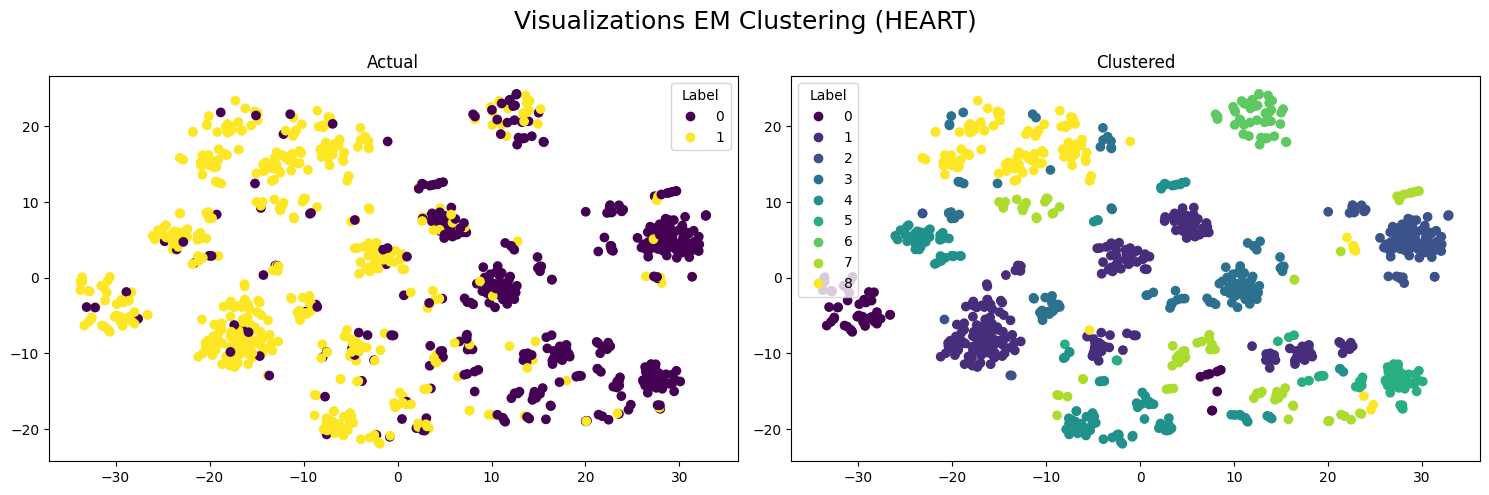

In [121]:
#Plotting Result
#Visualizing
tsne_vis=TSNE(n_components=2,perplexity=45,n_jobs=-1)

#Transforming dataset 1 based on ideal 
dataset_transformed=tsne_vis.fit_transform(dataset)

fig=plt.figure()
fig, axes = plt.subplots(1,2,figsize=(15, 5))

position_dict={}

plt.suptitle('Visualizations EM Clustering (HEART)',fontsize=18)
LABS=[labels_og,best_em_d2.predict(dataset)]

axis_int=0
for ax,labels_ in zip(axes,LABS):

    artists=[]
    sc=ax.scatter(dataset_transformed[:,0],dataset_transformed[:,1],c=labels_,cmap='viridis',zorder=1)
    # Overlay each image within the scatter plot

    if axis_int==0:
        ax.set_title(f'Actual')
        axis_int+=1
    else:
        ax.set_title(f'Clustered')

    ax.legend(*sc.legend_elements(), title='Label')
plt.tight_layout()

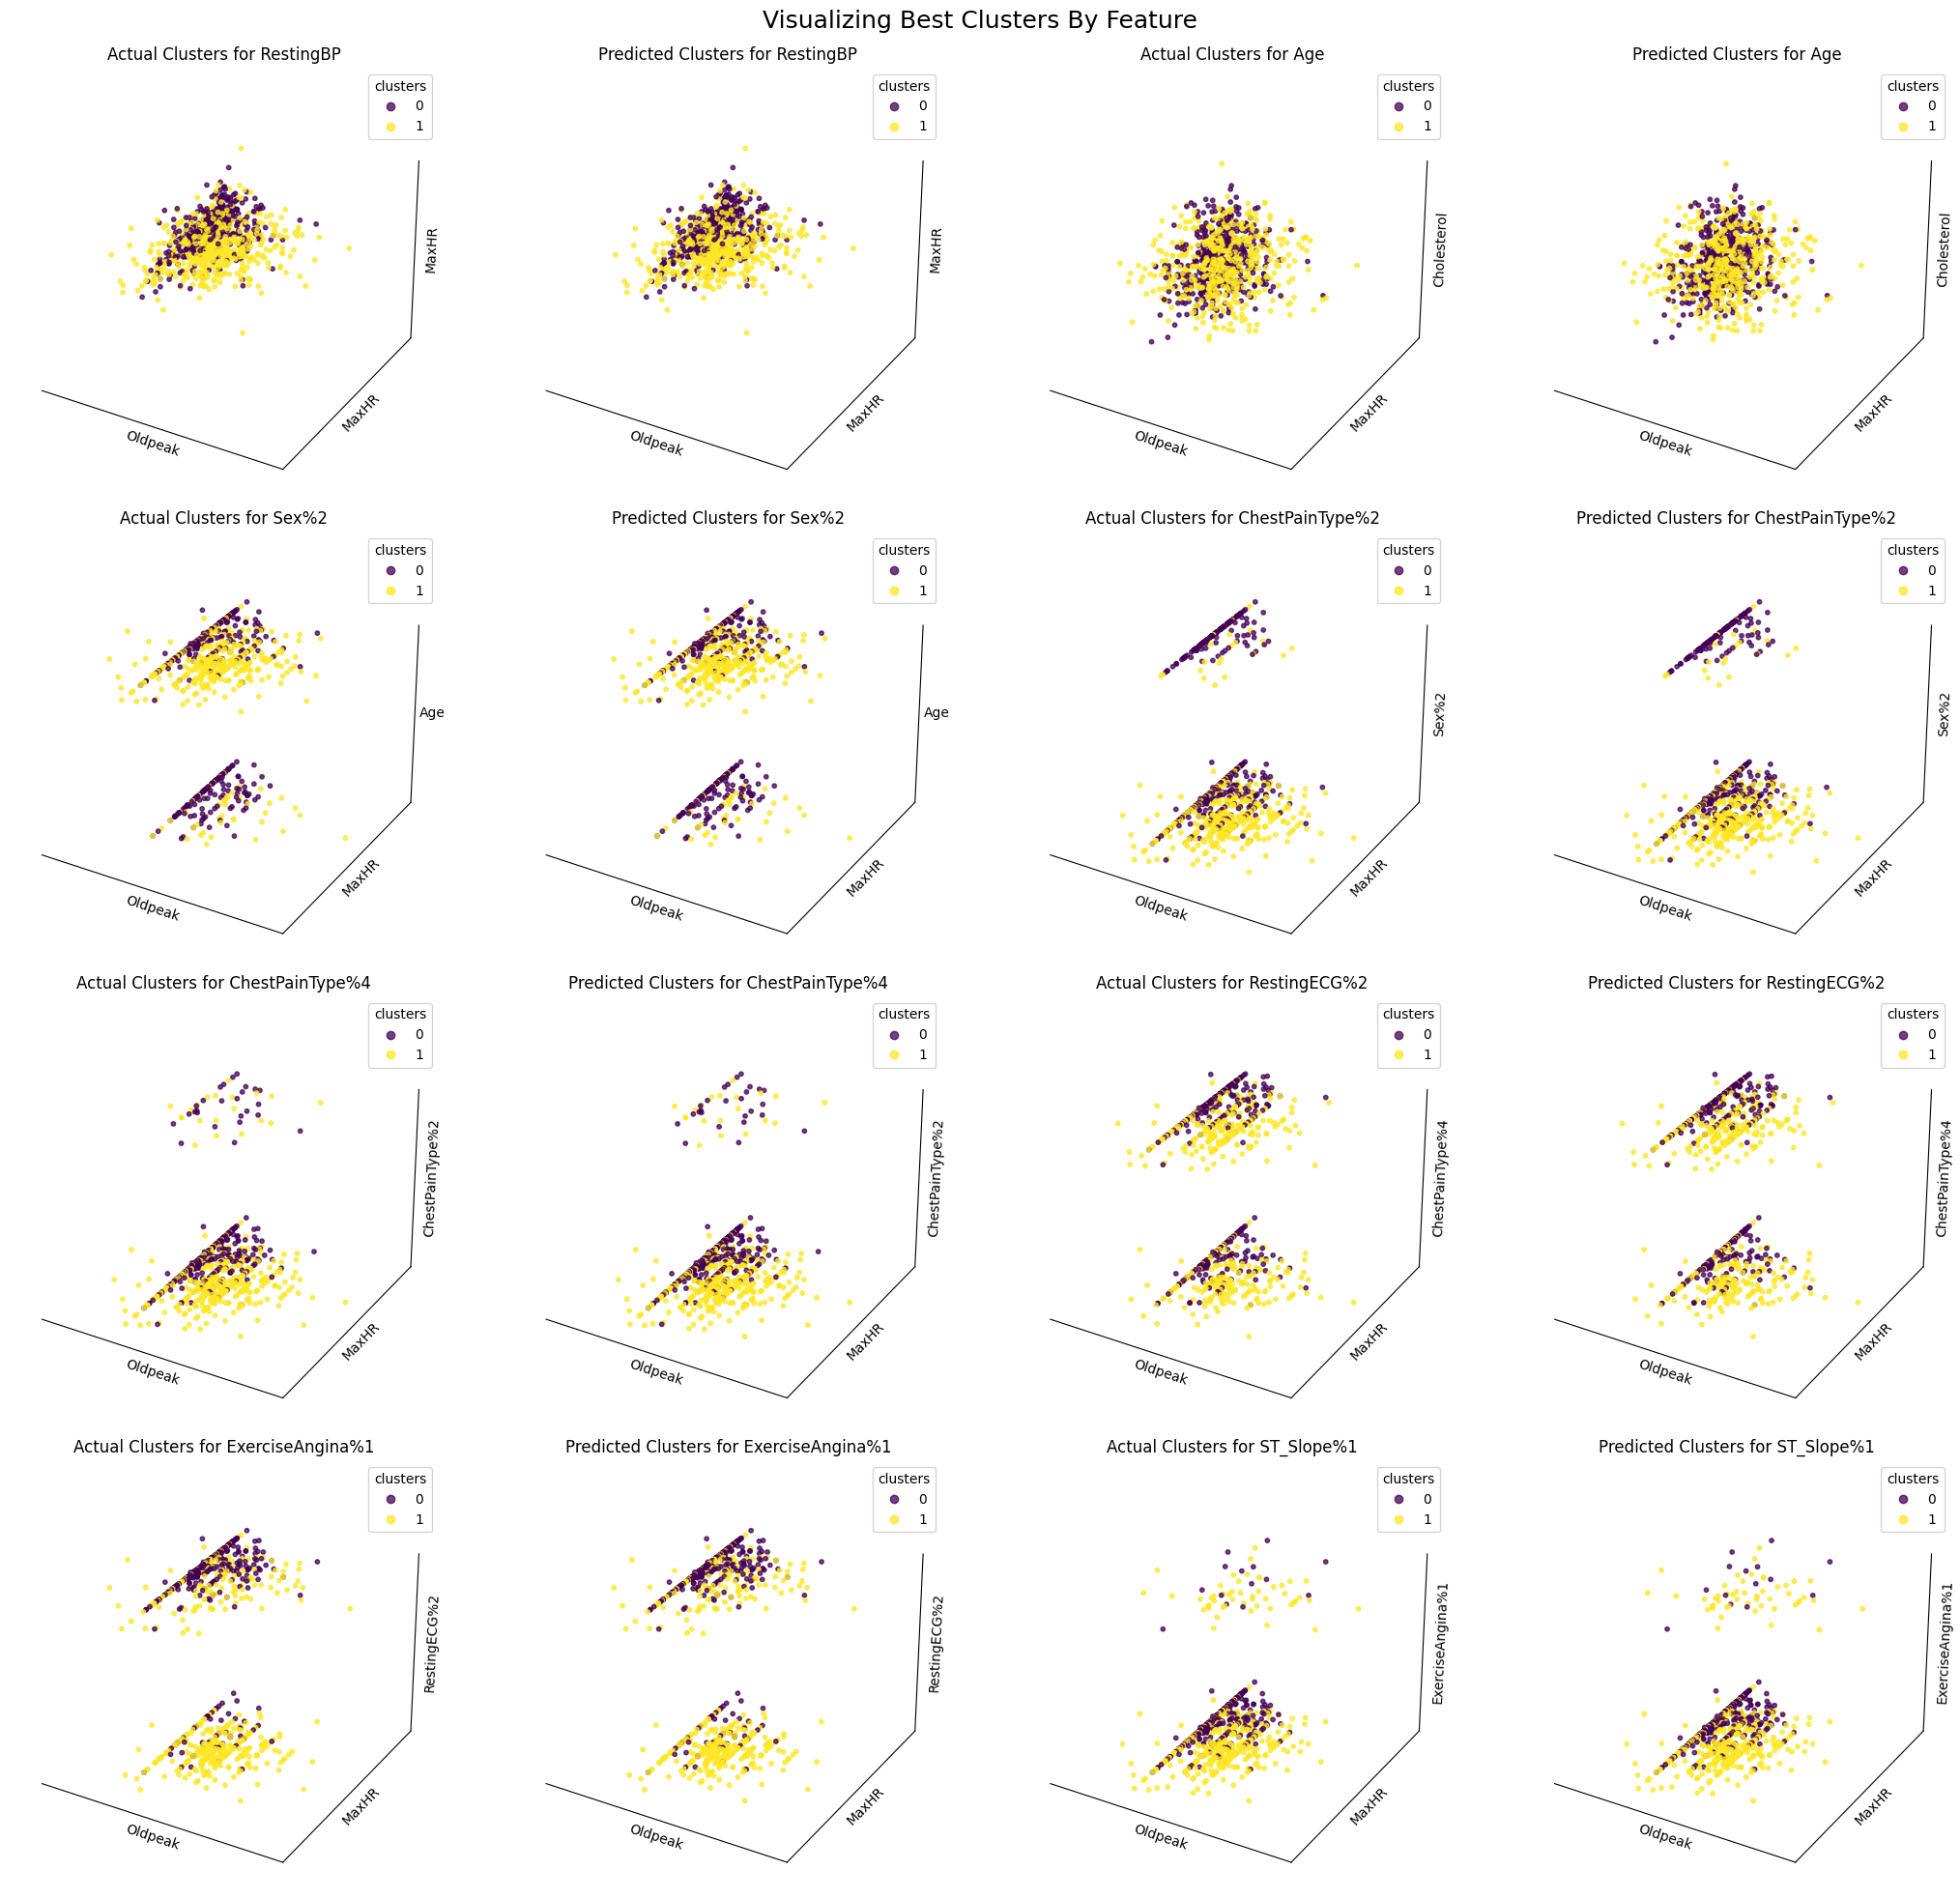

In [325]:
ROWS=4
#Plotting with actual labels

TWO_FIXED=['Oldpeak','MaxHR']
ind_1=heart_index[TWO_FIXED[0]]
ind_2=heart_index[TWO_FIXED[1]]

filter_cols=[i for i in range(len(heart_index)) if i not in (ind_1,ind_2)]
filtered_heart=X_heart_scaled[:,filter_cols]
reversed_dict={i:k for k,i in heart_index.items()}

fig,axes=plt.subplots(ROWS,4,subplot_kw={'projection': '3d'})
fig.set_size_inches(5*(len(reversed_dict)-4)/ROWS,5*ROWS)
plt.suptitle(f'Visualizing Best Clusters By Feature',fontsize=18)

for c,ax in enumerate(fig.axes):

    if c%2==0:
        #Plot Actual With Binary
        sc=ax.scatter(X_heart_scaled[:,ind_1],X_heart_scaled[:,ind_2],filtered_heart[:,c],c=labels_og,cmap='viridis',alpha=0.75,s=10)
        ax.set_xlabel(f'{TWO_FIXED[0]}',labelpad=-13)
        ax.set_ylabel(f'{TWO_FIXED[1]}',labelpad=-13)
        ax.set_zlabel(f'{reversed_dict[c]}',labelpad=-13)
        ax.set_title(f'Actual Clusters for {list(heart_index.keys())[filter_cols[c]]}')
        ax.legend(*sc.legend_elements(), title='clusters')
        
        # Remove fill
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.grid(False)

        #Plot Predicted Cluster
        sc=fig.axes[c+1].scatter(X_heart_scaled[:,ind_1],X_heart_scaled[:,ind_2],filtered_heart[:,c],c=labels,cmap='viridis',alpha=0.75,s=10)
        fig.axes[c+1].set_xlabel(f'{TWO_FIXED[0]}',labelpad=-13)
        fig.axes[c+1].set_ylabel(f'{TWO_FIXED[1]}',labelpad=-13)
        fig.axes[c+1].set_zlabel(f'{reversed_dict[c]}',labelpad=-13)
        fig.axes[c+1].set_title(f'Predicted Clusters for {list(heart_index.keys())[filter_cols[c]]}')
        fig.axes[c+1].legend(*sc.legend_elements(), title='clusters')
        
        # Remove fill
        fig.axes[c+1].xaxis.pane.fill = False
        fig.axes[c+1].yaxis.pane.fill = False
        fig.axes[c+1].zaxis.pane.fill = False
        fig.axes[c+1].xaxis.pane.set_edgecolor('w')
        fig.axes[c+1].yaxis.pane.set_edgecolor('w')
        fig.axes[c+1].zaxis.pane.set_edgecolor('w')
        fig.axes[c+1].set_xticks([])
        fig.axes[c+1].set_yticks([])
        fig.axes[c+1].set_zticks([])
        fig.axes[c+1].grid(False)

    else:
        continue
        continue

plt.tight_layout()
plt.subplots_adjust(top=0.95)

784it [19:18,  1.48s/it]
784it [19:34,  1.50s/it]
784it [19:01,  1.46s/it]

The lowest number of componenets to exceed the limit of 0.85 is 75


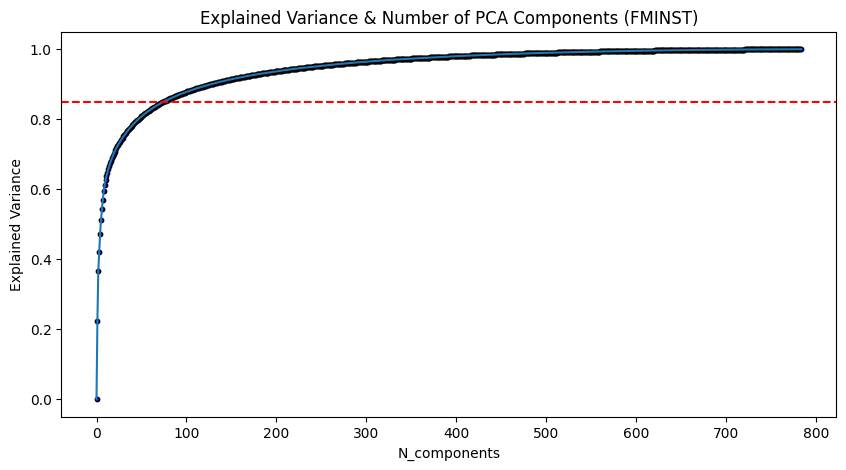

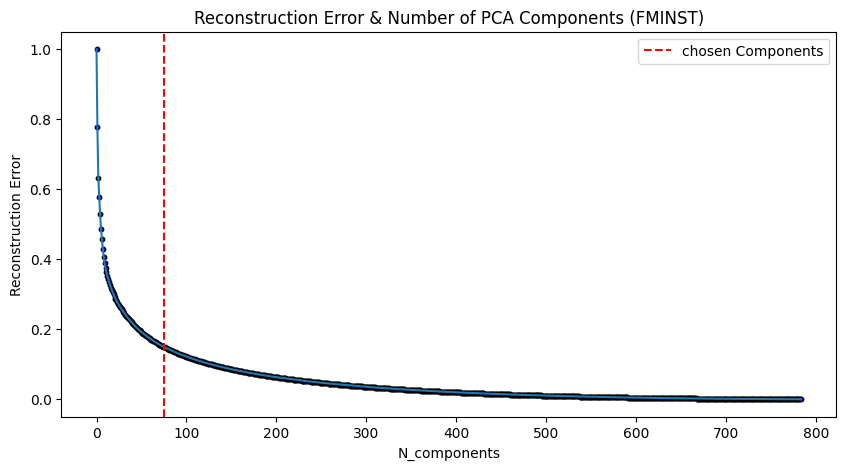

In [143]:
#Applying PCA on the FMINST Dataset

#Remembering that the number of features for FMINST are 784
dataset=X_fm_scaled
chosen_n_pca_d1=None

pca_size=range(785)
repeats=3
ideal_comps=None 
#LIMIT=0.90

explained_variance=np.zeros(len(pca_size))
reconstruction_error=np.zeros(len(pca_size))
ideal_components=None

for r in [21*(1+i) for i in range(repeats)]:

    for i_ind,i in tqdm(enumerate(pca_size)):
        p_comp=PCA(n_components=i,random_state=r)
        p_comp.fit(dataset)
        explained_variance[i_ind]+=sum(p_comp.explained_variance_ratio_)/repeats

        #Calcualting Reconstruction Error
        dataset_transformed=p_comp.transform(dataset)
        dataset_reconstructed=p_comp.inverse_transform(dataset_transformed)
        reconstruction_error[i_ind]+=mean_squared_error(dataset,dataset_reconstructed)/repeats

#Plotting explained variance 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Explained Variance & Number of PCA Components (FMINST)')
plt.plot(pca_size,explained_variance)
plt.scatter(pca_size, explained_variance, s=10, c='blue', marker='o', edgecolors='black')
plt.axhline(y=LIMIT,color='red',linestyle='--')
plt.xlabel('N_components')
plt.ylabel('Explained Variance')

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of PCA Components (FMINST)')
plt.plot(pca_size,reconstruction_error)
plt.scatter(pca_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.axvline(np.argwhere(explained_variance>LIMIT)[0][0],color='red',linestyle='--',label=f'chosen Components')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()

print('The lowest number of componenets to exceed the limit of {} is {}'.format(LIMIT,np.argwhere(explained_variance>LIMIT)[0][0]))
chosen_n_pca_d1=np.argwhere(explained_variance>LIMIT)[0][0]

The lowest number of componenets to exceed the limit of 0.875 is 97


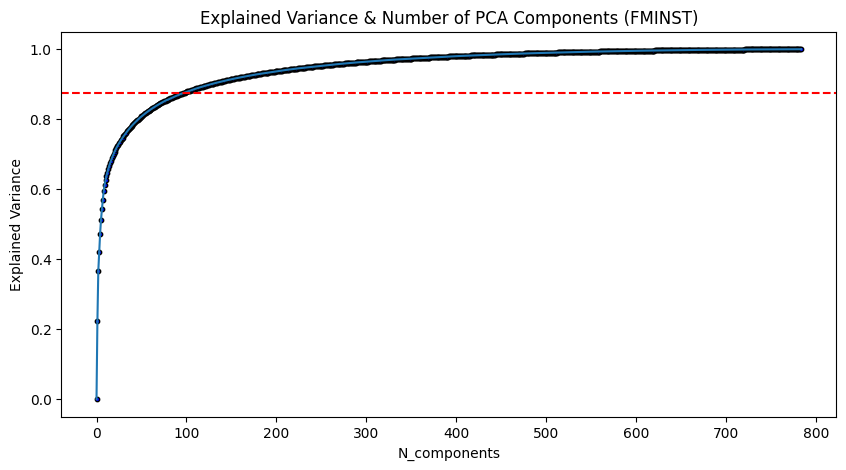

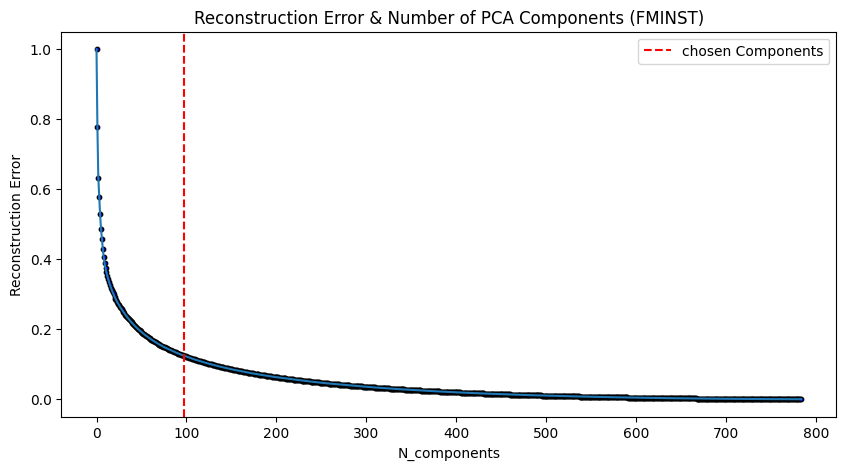

In [166]:
#Plotting explained variance 
LIMIT=0.875
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Explained Variance & Number of PCA Components (FMINST)')
plt.plot(pca_size,explained_variance)
plt.scatter(pca_size, explained_variance, s=10, c='blue', marker='o', edgecolors='black')
plt.axhline(y=LIMIT,color='red',linestyle='--')
plt.xlabel('N_components')
plt.ylabel('Explained Variance')

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of PCA Components (FMINST)')
plt.plot(pca_size,reconstruction_error)
plt.scatter(pca_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.axvline(np.argwhere(explained_variance>LIMIT)[0][0],color='red',linestyle='--',label=f'chosen Components')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()

print('The lowest number of componenets to exceed the limit of {} is {}'.format(LIMIT,np.argwhere(explained_variance>LIMIT)[0][0]))
chosen_n_pca_d1=np.argwhere(explained_variance>LIMIT)[0][0]

In [195]:
ideal_components=0
repeats=5
for i in range(repeats):
    p_comp=PCA(n_components=784,random_state=i)
    p_comp.fit(X_fm_scaled)
    cutoff=2.858*np.median(p_comp.singular_values_)
    ideal_components+=np.sum(p_comp.singular_values_>=cutoff)/repeats
print(ideal_components)

94.0


The lowest number of components to exceed the limit of 0.85 is 10


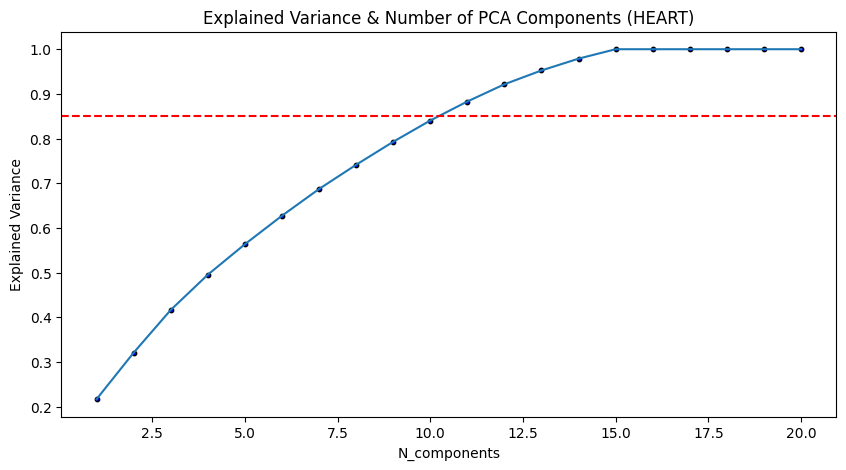

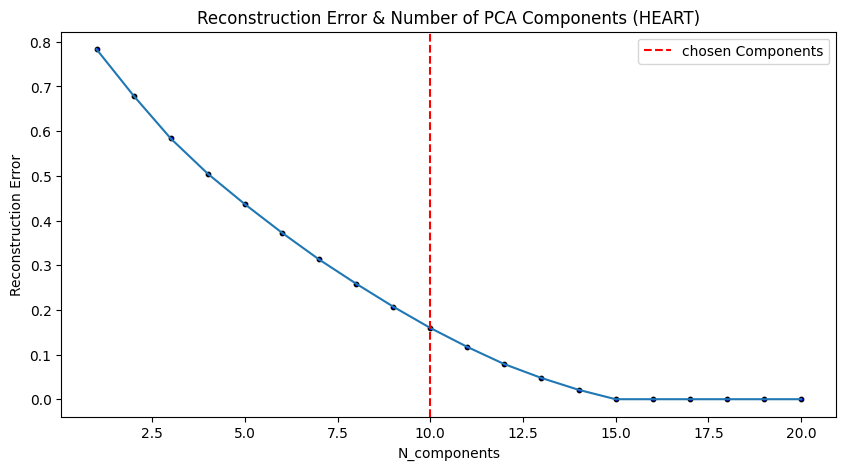

In [277]:
#Applying PCA on the FMINST Dataset

#Remembering that the number of features for FMINST are 784
dataset=X_heart_scaled
chosen_n_pca_d2=None

pca_size=range(1,21)
repeats=3
ideal_comps=None 
LIMIT=0.85

explained_variance=np.zeros(len(pca_size))
reconstruction_error=np.zeros(len(pca_size))

for r in [21*(1+i) for i in range(repeats)]:

    for i_ind,i in enumerate(pca_size):
        p_comp=PCA(n_components=i,random_state=r)
        p_comp.fit(dataset)
        explained_variance[i_ind]+=sum(p_comp.explained_variance_ratio_)/repeats

        #Calcualting Reconstruction Error
        dataset_transformed=p_comp.transform(dataset)
        dataset_reconstructed=p_comp.inverse_transform(dataset_transformed)
        reconstruction_error[i_ind]+=mean_squared_error(dataset,dataset_reconstructed)/repeats

#Plotting explained variance 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Explained Variance & Number of PCA Components (HEART)')
plt.plot(pca_size,explained_variance)
plt.scatter(pca_size, explained_variance, s=10, c='blue', marker='o', edgecolors='black')
plt.axhline(y=LIMIT,color='red',linestyle='--')
plt.xlabel('N_components')
plt.ylabel('Explained Variance')

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of PCA Components (HEART)')
plt.plot(pca_size,reconstruction_error)
plt.scatter(pca_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.axvline(np.argwhere(explained_variance>LIMIT)[0][0],color='red',linestyle='--',label=f'chosen Components')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()

print('The lowest number of components to exceed the limit of {} is {}'.format(LIMIT,np.argwhere(explained_variance>LIMIT)[0][0]))
chosen_n_pca_d2=np.argwhere(explained_variance>LIMIT)[0][0]

In [193]:
ideal_components=0
repeats=5
for i in range(repeats):
    p_comp=PCA(n_components=21,random_state=i)
    p_comp.fit(X_heart_scaled)
    cutoff=2.858*np.median(p_comp.singular_values_)
    ideal_components+=np.sum(p_comp.singular_values_>cutoff)/repeats
print(ideal_components)

0.0


<Figure size 640x480 with 0 Axes>

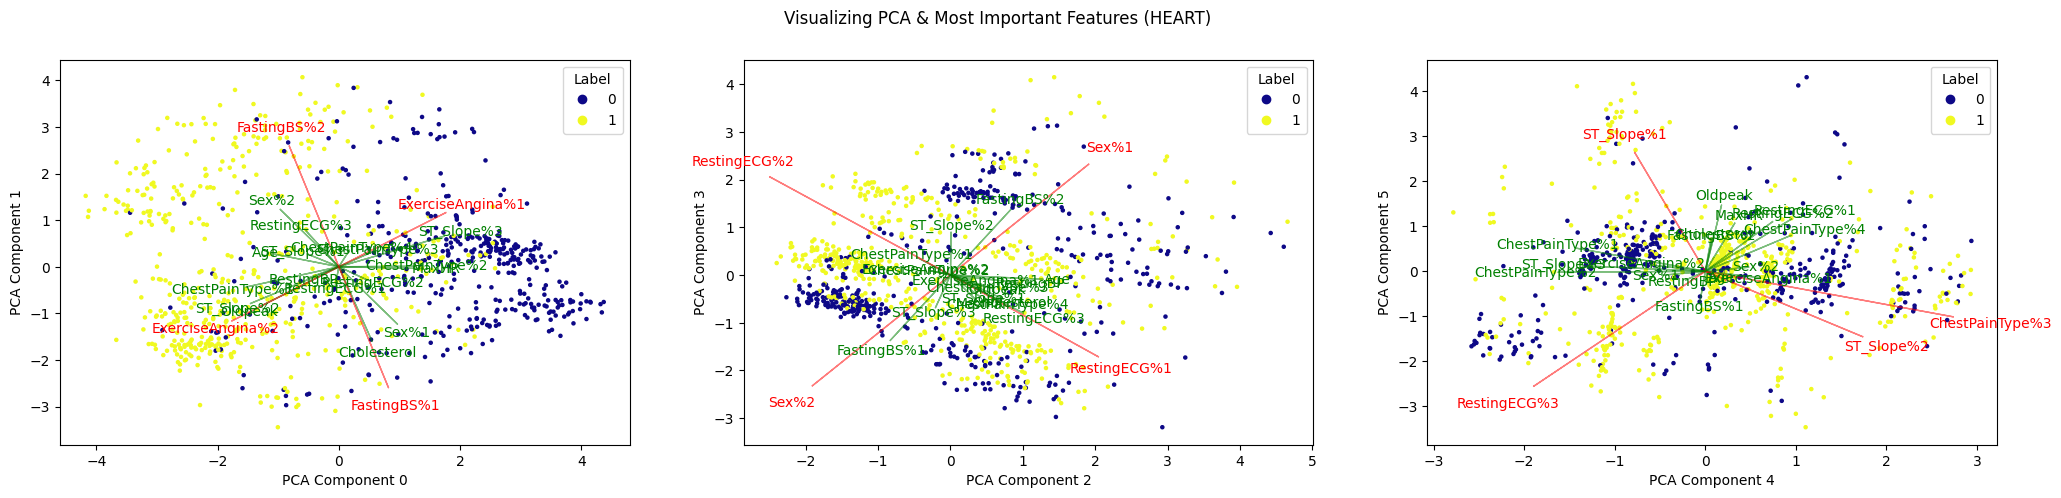

In [227]:
#Plotting the images for the componenets chosen
dataset=X_heart_scaled
labels=Y_heart
p_comp=PCA(n_components=11)
p_comp.fit(dataset)
PLOT_FACTOR=5

#Projecting the dataset into the first 2 dimensions to identify most important features
fig=plt.figure()
fig,axes=plt.subplots(1,3)
fig.set_size_inches(25,5)
plt.suptitle('Visualizing PCA & Most Important Features (HEART)')

sample_range=[[0,1],[2,3],[4,5]]

for sample,ax in zip(sample_range,axes):
    dataset_2d=np.dot(dataset,p_comp.components_[sample,:].T)
    
    sc=ax.scatter(dataset_2d[:,0],dataset_2d[:,1],c=labels,cmap='plasma',s=5)
    most_important=np.argsort(np.abs(p_comp.components_[sample]).sum(axis=0))[::-1][:4].ravel()

    for i in range(dataset.shape[-1]):
        if i in most_important:
            ax.arrow(0,0,p_comp.components_[sample,i].T[0]*PLOT_FACTOR,p_comp.components_[sample,i].T[1]*PLOT_FACTOR,color='r',alpha=0.5)
            ax.text(p_comp.components_[sample,i].T[0]*PLOT_FACTOR*1.15,p_comp.components_[sample,i].T[1]*PLOT_FACTOR*1.15,s=list(heart_index.keys())[i],color = 'r', ha = 'center', va = 'center')
        else:
            ax.arrow(0,0,p_comp.components_[sample,i].T[0]*PLOT_FACTOR,p_comp.components_[sample,i].T[1]*PLOT_FACTOR,color='g',alpha=0.5)
            ax.text(p_comp.components_[sample,i].T[0]*PLOT_FACTOR*1.15,p_comp.components_[sample,i].T[1]*PLOT_FACTOR*1.15,s=list(heart_index.keys())[i],color = 'g', ha = 'center', va = 'center')        
    ax.set_xlabel(f'PCA Component {sample[0]}')
    ax.set_ylabel(f'PCA Component {sample[1]}')
    ax.legend(*sc.legend_elements(), title='Label');

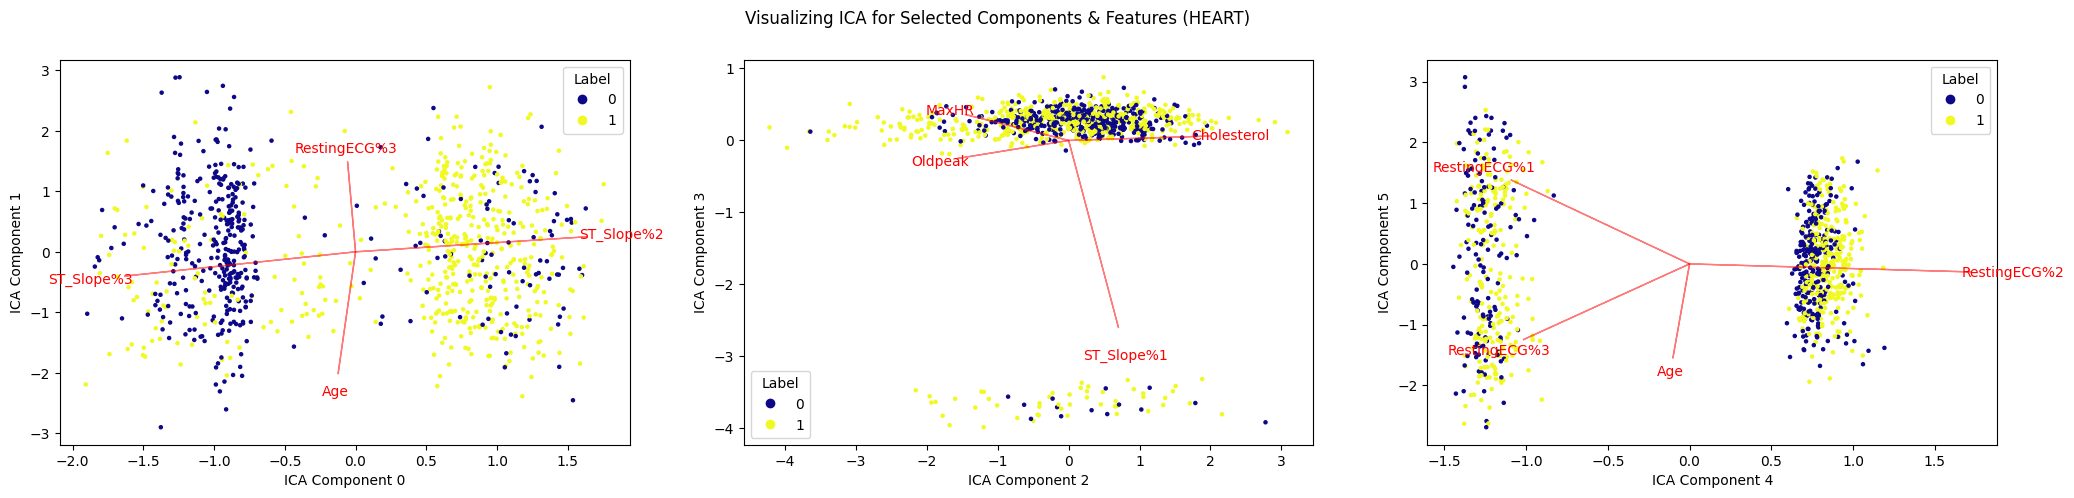

In [313]:
chosen_n_ica_d2=14
r=63
dataset=X_heart_scaled
#chosen_n_ica_d2=ica_size[np.argmax(kurtosis)]
ica_comp=FastICA(n_components=chosen_n_ica_d2,random_state=r,max_iter=100000)
d2_ica=ica_comp.fit_transform(dataset)

correlation_matrix = np.corrcoef(d2_ica.T)

# # Plot heatmap of new dataset 
# plt.figure(figsize=(10, 5))
# sns.heatmap(correlation_matrix, cmap='magma', fmt=".2f", cbar=True)
# plt.title('Correlation Matrix of Independent Components (HEART)')
# plt.xlabel('Component Index')
# plt.ylabel('Component Index')
# plt.show()

# correlation_matrix = np.corrcoef(dataset.T)

# # Plot heatmap of old dataset 
# plt.figure(figsize=(10, 5))
# sns.heatmap(correlation_matrix, cmap='magma', fmt=".2f", cbar=True)
# plt.title('Correlation Matrix of Original Features (HEART)')
# plt.xlabel('Feature Index')
# plt.ylabel('Feature Index')
# plt.show()

#Projecting the dataset into the first 2 dimensions
fig,axes=plt.subplots(1,3)
fig.set_size_inches(25,5)
plt.suptitle('Visualizing ICA for Selected Components & Features (HEART)')

SELECTION=[[0,1],[2,3],[4,5]]

for ii,ica_select in enumerate(SELECTION):
    PLOT_FACTOR=3
    ICA_COMP_1=ica_select[0]
    ICA_COMP_2=ica_select[1]

    filtered_components=ica_comp.components_[[ICA_COMP_1,ICA_COMP_2]]
    dataset_2d=np.dot(dataset,filtered_components.T)


    sc=axes[ii].scatter(dataset_2d[:,0],dataset_2d[:,1],c=labels,cmap='plasma',s=5)
    most_important=np.argsort(np.abs(filtered_components).sum(axis=0))[::-1][:4].ravel()

    for i in range(dataset.shape[-1]):
        if i in most_important:
            axes[ii].arrow(0,0,filtered_components[:,i].T[0]*PLOT_FACTOR,filtered_components[:,i].T[1]*PLOT_FACTOR,color='r',alpha=0.5)
            axes[ii].text(filtered_components[:,i].T[0]*PLOT_FACTOR*1.15,filtered_components[:,i].T[1]*PLOT_FACTOR*1.15,s=list(heart_index.keys())[i],color = 'r', ha = 'center', va = 'center')
        else:
            pass
            #plt.arrow(0,0,ica_comp.components_[:2,i].T[0]*PLOT_FACTOR,ica_comp.components_[:2,i].T[1]*PLOT_FACTOR,color='g',alpha=0.5)
            #plt.text(ica_comp.components_[:2,i].T[0]*PLOT_FACTOR*1.15,ica_comp.components_[:2,i].T[1]*PLOT_FACTOR*1.15,s=list(heart_index.keys())[i],color = 'g', ha = 'center', va = 'center')        
    axes[ii].set_xlabel(f'ICA Component {ICA_COMP_1}')
    axes[ii].set_ylabel(f'ICA Component {ICA_COMP_2}')
    axes[ii].legend(*sc.legend_elements(), title='Label');

20it [12:34, 37.73s/it]


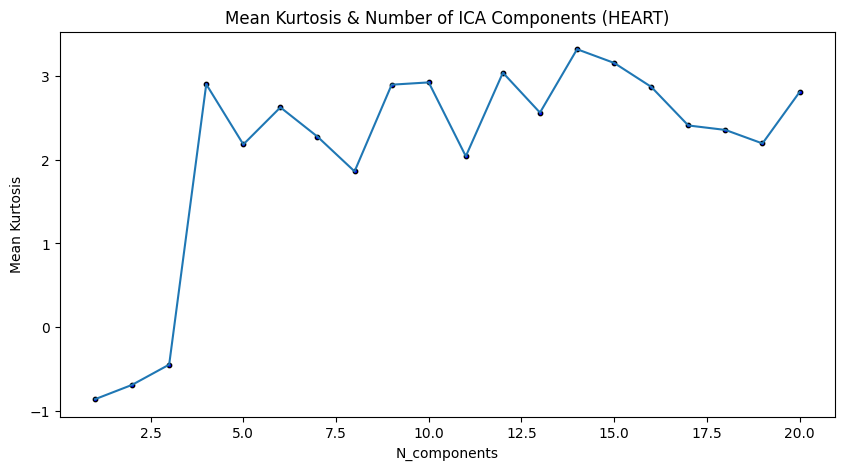

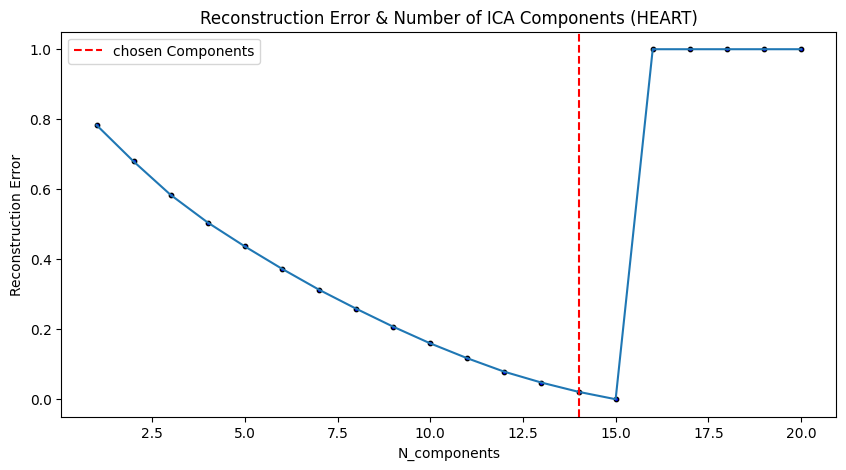

In [274]:
#Applying ICA on the Heart Dataset

#Remembering that the number of features for FMINST are 784
dataset=X_heart_scaled
chosen_n_ica_d1=None

ica_size=range(1,21)
repeats=3
ideal_comps=None 

kurtosis=np.zeros(len(ica_size))
reconstruction_error=np.zeros(len(ica_size))

for i_ind,i in tqdm(enumerate(ica_size)):
    
    for r in [21*(1+i) for i in range(repeats)]:

        ica_comp=FastICA(n_components=i,random_state=r,max_iter=100000,tol=0.0001)
        ica_comp.fit(dataset)
        kurtosis[i_ind]+=scipy.stats.kurtosis(np.abs(ica_comp.transform(dataset))).mean()/repeats

        #Getting error
        dataset_transformed=ica_comp.transform(dataset)
        dataset_reconstructed=ica_comp.inverse_transform(dataset_transformed)
        error=mean_squared_error(dataset,dataset_reconstructed)

        if error<1*10-10:
            error=0

        reconstruction_error[i_ind]+=error/repeats

#Plotting explained variance 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Mean Kurtosis & Number of ICA Components (HEART)')
plt.plot(ica_size,kurtosis)
plt.scatter(ica_size, kurtosis, s=10, c='blue', marker='o', edgecolors='black')
plt.xlabel('N_components')
plt.ylabel('Mean Kurtosis')

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of ICA Components (HEART)')
plt.plot(ica_size,reconstruction_error)
plt.scatter(ica_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.axvline(ica_size[np.argmax(kurtosis)],color='red',linestyle='--',label=f'chosen Components')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()

In [276]:
reconstruction_error_ica=reconstruction_error.copy()

In [278]:
reconstruction_error

array([7.83413534e-01, 6.79421304e-01, 5.83739836e-01, 5.04801127e-01,
       4.36605486e-01, 3.72782328e-01, 3.12935982e-01, 2.58727666e-01,
       2.07249841e-01, 1.59597393e-01, 1.17028979e-01, 7.84917317e-02,
       4.75102436e-02, 2.10845016e-02, 1.45440811e-30, 1.45494623e-30,
       1.06335463e-30, 1.05221513e-30, 1.05666345e-30, 1.05331786e-30])

In [285]:
((reconstruction_error-reconstruction_error_ica)/reconstruction_error_ica)[:-5]

array([ 1.85931509e-13,  7.59689343e-10,  5.14998336e-07,  4.71786183e-06,
        0.00000000e+00,  1.48910362e-16,  3.54776405e-16,  0.00000000e+00,
        1.33923266e-16, -3.47819912e-16,  0.00000000e+00, -5.30417186e-16,
        5.84201922e-16,  4.93648892e-16, -1.63320506e-01])

In [314]:
#Applying Gaussian Random Projection on the FMINST Dataset

#Remembering that the number of features for FMINST are 784
dataset=X_fm_scaled
chosen_n_rgp_d1=None

rgp_size=range(1,1000)
repeats=3
ideal_comps=None 

original_distance=scipy.spatial.distance.pdist(dataset)
reconstruction_error=np.zeros(len(rgp_size))
pairwise_distance_error=np.zeros(len(rgp_size))

for i_ind,i in tqdm(enumerate(rgp_size)):
    
    for r in [21*(1+i) for i in range(repeats)]:
    
        rgp_comp=GaussianRandomProjection(n_components=i,random_state=r)
        rgp_comp.fit(dataset)

        #Getting error
        dataset_transformed=rgp_comp.transform(dataset)
        dataset_reconstructed=rgp_comp.inverse_transform(dataset_transformed)
        error=mean_squared_error(dataset,dataset_reconstructed)
        reconstruction_error[i_ind]+=error/3

        #Calculating Pairwise Distance
        pairwise_distance_error[i_ind]+=((original_distance-scipy.spatial.distance.pdist(dataset_transformed))**2).sum()/3

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of Random Gaussian Projection Components (FMINST)')
plt.plot(rgp_size,reconstruction_error)
plt.scatter(rgp_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')

#Plotting Pairwise Distance 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Pairwise Distance Error & Number of Random Gaussian Projection Components (FMINST)')
plt.plot(rgp_size,pairwise_distance_error)
plt.scatter(rgp_size, pairwise_distance_error, s=10, c='blue', marker='o', edgecolors='black')
plt.xlabel('N_components')
plt.ylabel('Pairwise Distance Error')

304it [18:24,  3.63s/it]


KeyboardInterrupt: 

In [321]:
import time

repeats=10
dataset=X_fm_scaled
print('FMINST\n')

start=time.time()
for i in range(repeats):
    rgp_comp=GaussianRandomProjection(n_components=666,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average RGP runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=PCA(n_components=75,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average PCA runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=FastICA(n_components=66,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average ICA runtime of {} s'.format((end-start)/repeats))

FMINST

Average RGP runtime of 0.020604825019836424 s
Average PCA runtime of 0.20324761867523194 s
Average ICA runtime of 1.2222312450408936 s


In [322]:
import time

repeats=10
dataset=X_heart_scaled
print('HEART\n')

start=time.time()
for i in range(repeats):
    rgp_comp=GaussianRandomProjection(n_components=17,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average RGP runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=PCA(n_components=11,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average PCA runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=FastICA(n_components=14,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average ICA runtime of {} s'.format((end-start)/repeats))

HEART

Average RGP runtime of 0.00030007362365722654 s
Average PCA runtime of 0.0032007694244384766 s
Average ICA runtime of 0.012502694129943847 s


In [329]:
#Applying ISOMAP Manifold Learning on the FMINST Dataset

dataset=X_fm_scaled
chosen_n_iso_map_d1=None
chosen_neighbors_d1=None

n_comps=range(2,100)
num_neighbors=[30,45,60]
repeats=3
ideal_comps=None 

trustworthiness_scores=np.zeros(shape=(len(n_comps),len(num_neighbors)))
reconstruction_errors=np.zeros(shape=(len(n_comps),len(num_neighbors)))

for i,n in tqdm(enumerate(n_comps)):

    for ii,neighbors in enumerate(num_neighbors):

        iso_map_comp=Isomap(n_components=n,n_neighbors=neighbors,n_jobs=-1)
        dataset_transformed=iso_map_comp.fit_transform(dataset)

        trustworthiness_scores[i,ii]=trustworthiness(dataset,dataset_transformed,n_neighbors=neighbors,)
        reconstruction_errors[i,ii]=iso_map_comp.reconstruction_error()

fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Trustworthiness Score, Num Neighbors & N_Components (FMINST)');
for ii,neighbors in enumerate(num_neighbors):
    plt.scatter(n_comps,trustworthiness_scores[:,ii],label=f'Num Neighbours {neighbors}')
    plt.plot(n_comps,trustworthiness_scores[:,ii])
    plt.legend()
plt.xlabel('N_Components')
plt.ylabel('Trustworthiness Score')

fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Reconstruction Error, Num Neighbors & N_Components (FMINST)');
for ii,neighbors in enumerate(num_neighbors):
    plt.scatter(n_comps,reconstruction_errors[:,ii],label=f'Num Neighbours {neighbors}')
    plt.plot(n_comps,reconstruction_errors[:,ii])
    plt.legend()
plt.xlabel('N_Components')
plt.ylabel('Reconstruction Error')

0it [00:24, ?it/s]


KeyboardInterrupt: 

In [331]:
import time

repeats=10
dataset=X_fm_scaled
print('FMINST\n')

start=time.time()
for i in range(repeats):
    rgp_comp=GaussianRandomProjection(n_components=666,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average RGP runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=PCA(n_components=75,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average PCA runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=FastICA(n_components=66,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average ICA runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=Isomap(n_components=20,n_neighbors=45,n_jobs=-1)
    rgp_comp.fit(dataset)
end=time.time()

print('Average ISOMAP runtime of {} s'.format((end-start)/repeats))


FMINST

Average RGP runtime of 0.01270294189453125 s
Average PCA runtime of 0.26386203765869143 s
Average ICA runtime of 1.2773659944534301 s
Average ISOMAP runtime of 37.90716664791107 s


In [332]:
import time

repeats=10
dataset=X_heart_scaled
print('HEART\n')

start=time.time()
for i in range(repeats):
    rgp_comp=GaussianRandomProjection(n_components=17,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average RGP runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=PCA(n_components=11,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average PCA runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=FastICA(n_components=14,random_state=r)
    rgp_comp.fit(dataset)
end=time.time()

print('Average ICA runtime of {} s'.format((end-start)/repeats))

start=time.time()
for i in range(repeats):
    rgp_comp=Isomap(n_components=20,n_neighbors=45,n_jobs=-1)
    rgp_comp.fit(dataset)
end=time.time()

print('Average ISOMAP runtime of {} s'.format((end-start)/repeats))

HEART

Average RGP runtime of 0.004200887680053711 s
Average PCA runtime of 0.003200840950012207 s
Average ICA runtime of 0.013203096389770509 s
Average ISOMAP runtime of 0.6050177812576294 s


<Figure size 640x480 with 0 Axes>

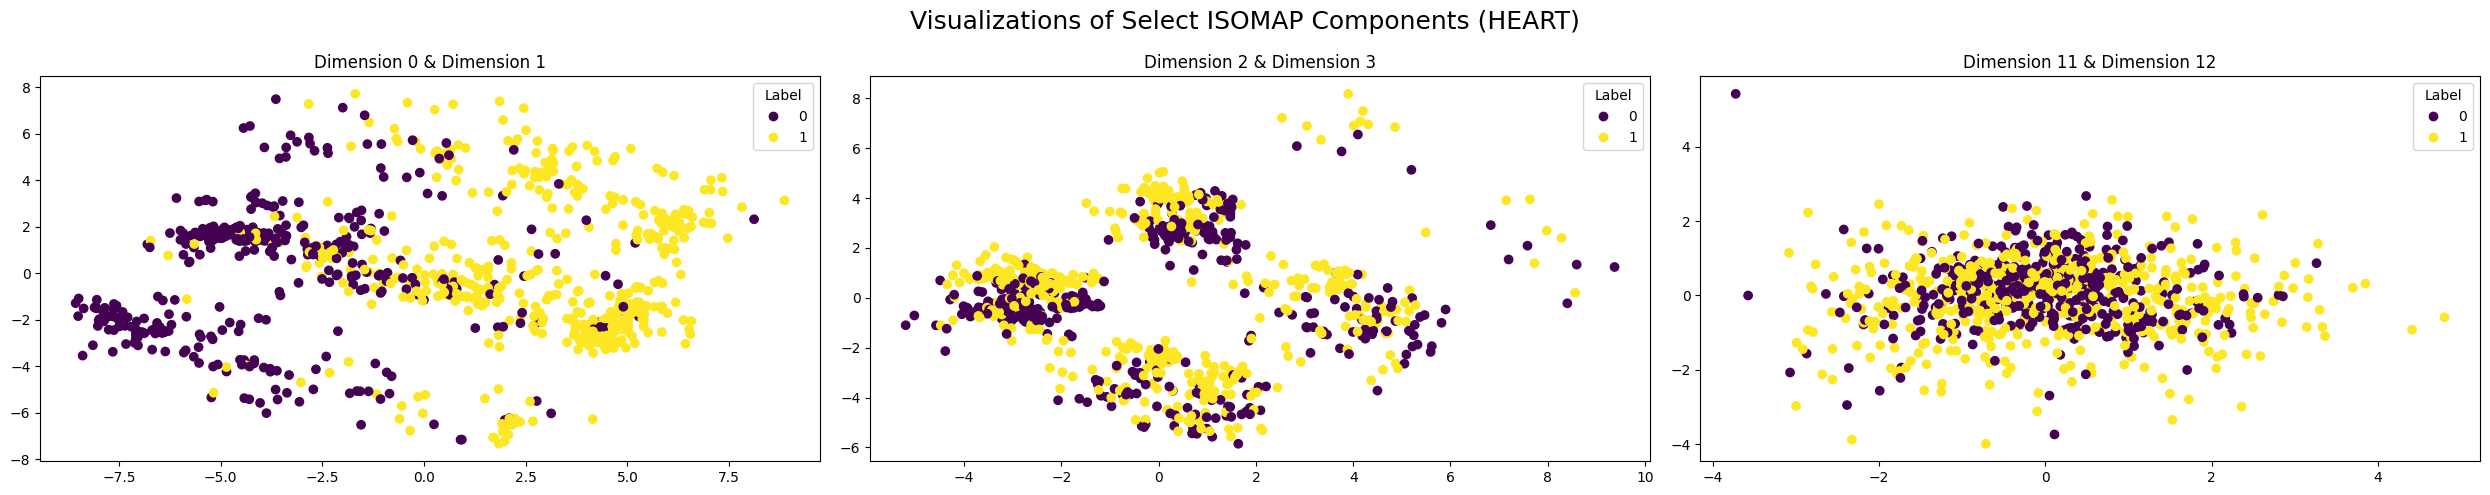

In [343]:
#Creating ideal ISOMAP manifold 
chosen_n_iso_map_d2=13
chosen_neighbors_d2=45
dataset=X_heart_scaled
labels=Y_heart

#iso_map_d1=umap.UMAP(n_components=chosen_n_iso_map_d1,n_neighbors=chosen_neighbors_d1,n_jobs=-1)
iso_map_d2=Isomap(n_components=chosen_n_iso_map_d2,n_neighbors=chosen_neighbors_d2,n_jobs=-1)

#Transforming dataset 1 based on ideal 
dataset_transformed=iso_map_d2.fit_transform(dataset)

#Visualizing transformed data
fig=plt.figure()
fig, axes = plt.subplots(1,3,figsize=(25, 5))
position_dict={}

plt.suptitle('Visualizations of Select ISOMAP Components (HEART)',fontsize=18)

SELECTION=[[0,1],[2,3],[11,12]]

for ax,dims in zip(axes,SELECTION):
    artists = []
    dim_1=dims[0]
    dim_2=dims[1]

    # for lab in np.unique(Y_fm):
    #     x,y=dataset_transformed[labels==lab][:,dim_1].mean(),dataset_transformed[labels==lab][:,dim_2].mean()
    #     position_dict[lab]=[x,y]

    sc=ax.scatter(dataset_transformed[:,dim_1],dataset_transformed[:,dim_2],c=labels,cmap='viridis',zorder=1)
    # Overlay each image within the scatter plot
    # for lab in np.unique(Y_fm):
    #     # Positioning Images
    #     image_x = position_dict[lab][0]
    #     image_y = position_dict[lab][1]
    #     im=OffsetImage(dataset[labels==lab][0].reshape(28,28),cmap='gray')
    #     ab = AnnotationBbox(im, (image_x, image_y), xycoords='data', frameon=False)
    #     artists.append(ax.add_artist(ab))
    ax.set_title(f'Dimension {dim_1} & Dimension {dim_2}')

    ax.legend(*sc.legend_elements(), title='Label')
plt.tight_layout()

20it [00:00, 90.48it/s] 


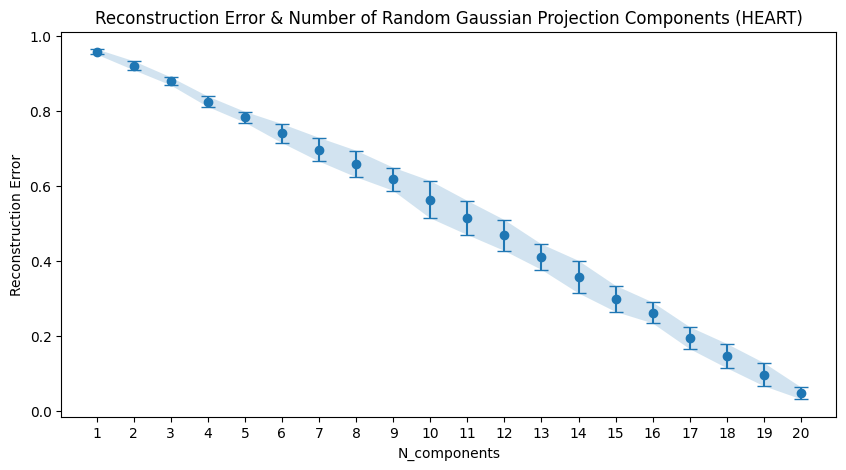

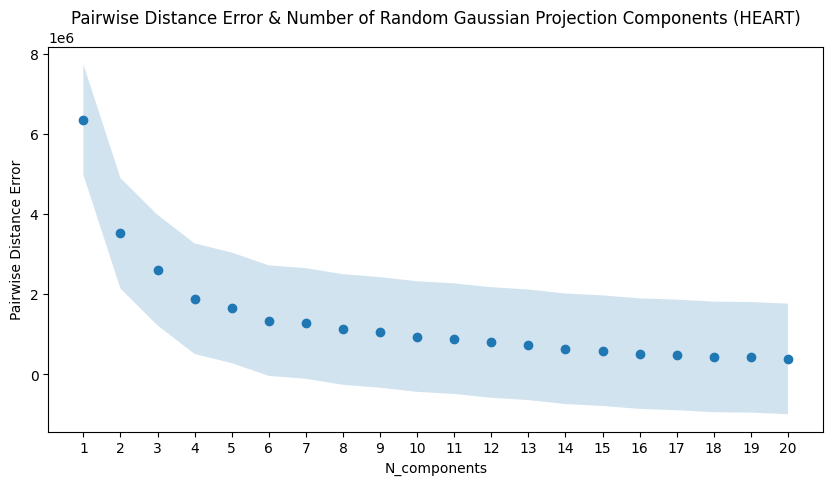

In [23]:
#Applying Gaussian Random Projection on the Heart Dataset

dataset=X_heart_scaled
chosen_n_rgp_d2=None

rgp_size=range(1,21)
repeats=3
ideal_comps=None 

original_distance=scipy.spatial.distance.pdist(dataset)
reconstruction_error=np.zeros(len(rgp_size))
reconstruction_vals=np.zeros(shape=(len(rgp_size),repeats))
pairwise_distance_error=np.zeros(len(rgp_size))


for i_ind,i in tqdm(enumerate(rgp_size)):

    for ix,r in enumerate([21*(1+i) for i in range(repeats)]):
        
        rgp_comp=GaussianRandomProjection(n_components=i,random_state=r)
        rgp_comp.fit(dataset)

        #Getting error
        dataset_transformed=rgp_comp.transform(dataset)
        dataset_reconstructed=rgp_comp.inverse_transform(dataset_transformed)
        error=mean_squared_error(dataset,dataset_reconstructed)
        reconstruction_error[i_ind]+=error/3
        reconstruction_vals[i_ind,ix]=error

        #Calculating Pairwise Distance
        pairwise_distance_error[i_ind]+=((original_distance-scipy.spatial.distance.pdist(dataset_transformed))**2).sum()/3

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of Random Gaussian Projection Components (HEART)')
plt.plot(rgp_size,reconstruction_error)
plt.scatter(rgp_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.xticks(rgp_size);

#Plotting Pairwise Distance 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Pairwise Distance Error & Number of Random Gaussian Projection Components (HEART)')
plt.plot(rgp_size,pairwise_distance_error)
plt.scatter(rgp_size, pairwise_distance_error, s=10, c='blue', marker='o', edgecolors='black')
plt.xlabel('N_components')
plt.ylabel('Pairwise Distance Error')
plt.xticks(rgp_size);

In [21]:
reconstruction_vals.std(axis=1)

array([0.006975  , 0.01198845, 0.01067492, 0.01402867, 0.01446023,
       0.02531735, 0.03161909, 0.03550967, 0.03089768, 0.04982667,
       0.04561709, 0.04129736, 0.03414942, 0.04342108, 0.03492925,
       0.02800709, 0.02933599, 0.03250174, 0.03101152, 0.01594282])

20it [00:00, 50.88it/s]


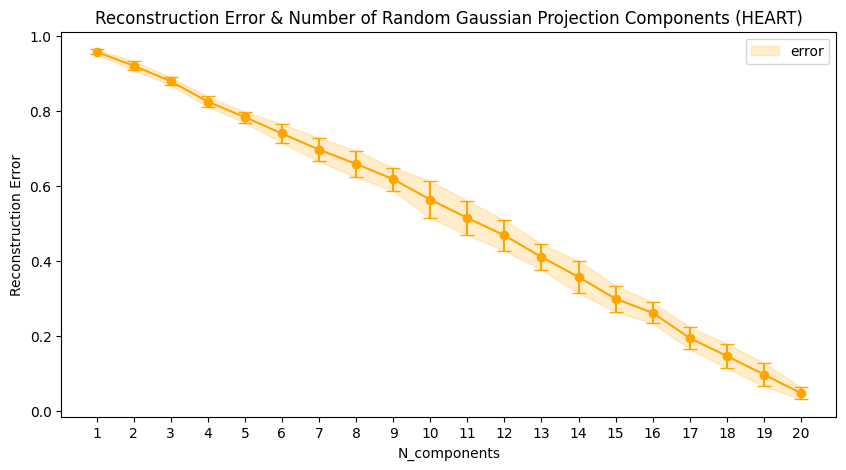

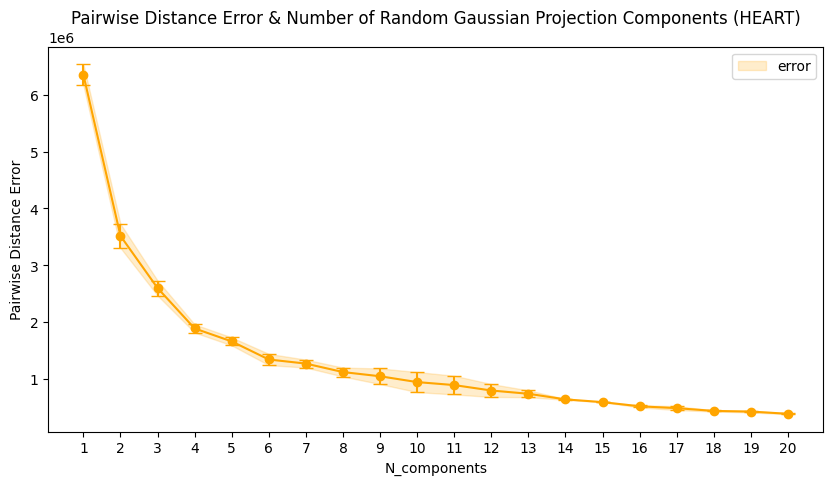

In [36]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Sample data and calculations
dataset = X_heart_scaled
rgp_size = range(1, 21)
repeats = 3
original_distance = scipy.spatial.distance.pdist(dataset)
reconstruction_error = np.zeros(len(rgp_size))
reconstruction_vals = np.zeros(shape=(len(rgp_size), repeats))
pairwise_distance_error = np.zeros(len(rgp_size))
pairwise_distance_errors= np.zeros(shape=(len(rgp_size), repeats))

for i_ind, i in tqdm(enumerate(rgp_size)):
    for ix, r in enumerate([21 * (1 + i) for i in range(repeats)]):
        rgp_comp = GaussianRandomProjection(n_components=i, random_state=r)
        rgp_comp.fit(dataset)

        dataset_transformed = rgp_comp.transform(dataset)
        dataset_reconstructed = rgp_comp.inverse_transform(dataset_transformed)
        error = mean_squared_error(dataset, dataset_reconstructed)
        reconstruction_error[i_ind] += error / 3
        reconstruction_vals[i_ind, ix] = error

        pairwise_distance_error[i_ind]+=((original_distance-scipy.spatial.distance.pdist(dataset_transformed))**2).sum()/3
        pairwise_distance_errors[i_ind, ix]=((original_distance-scipy.spatial.distance.pdist(dataset_transformed))**2).sum()

# Plotting reconstruction error with filled space between error bars
fig = plt.figure()
fig.set_size_inches(10, 5)

plt.title('Reconstruction Error & Number of Random Gaussian Projection Components (HEART)')
plt.errorbar(rgp_size, reconstruction_error, yerr=np.std(reconstruction_vals, axis=1), fmt='o', capsize=5,color='orange')
plt.fill_between(rgp_size, reconstruction_error - np.std(reconstruction_vals, axis=1), reconstruction_error + np.std(reconstruction_vals, axis=1), alpha=0.2,color='orange',label='error')
plt.plot(rgp_size,reconstruction_error,color='orange')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.xticks(rgp_size);

# Plotting Pairwise Distance with filled space between error bars
fig = plt.figure()
fig.set_size_inches(10, 5)

plt.title('Pairwise Distance Error & Number of Random Gaussian Projection Components (HEART)')
plt.errorbar(rgp_size, pairwise_distance_error, yerr=np.std(pairwise_distance_errors, axis=1), fmt='o', capsize=5,color='orange')
plt.fill_between(rgp_size, pairwise_distance_error - np.std(pairwise_distance_errors, axis=1), pairwise_distance_error + np.std(pairwise_distance_errors, axis=1), alpha=0.2, color='orange',label='error')
plt.plot(rgp_size,pairwise_distance_error, color='orange')
plt.xlabel('N_components')
plt.ylabel('Pairwise Distance Error')
plt.xticks(rgp_size);
plt.legend()

plt.show()

999it [5:22:29, 19.37s/it]


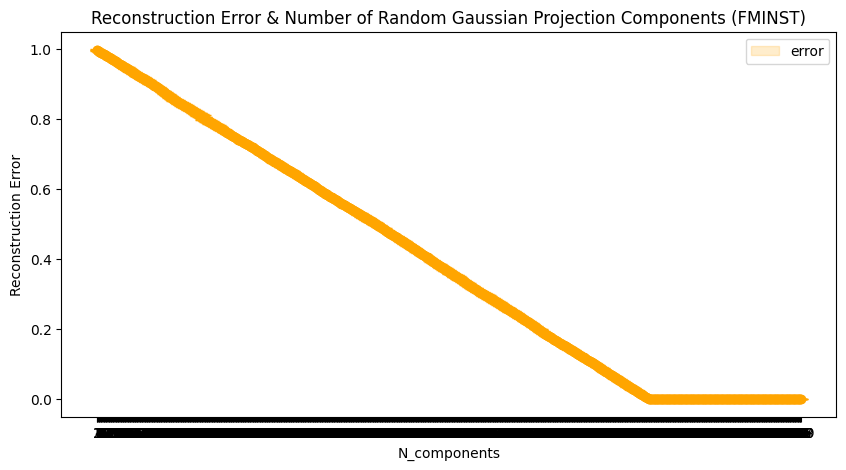

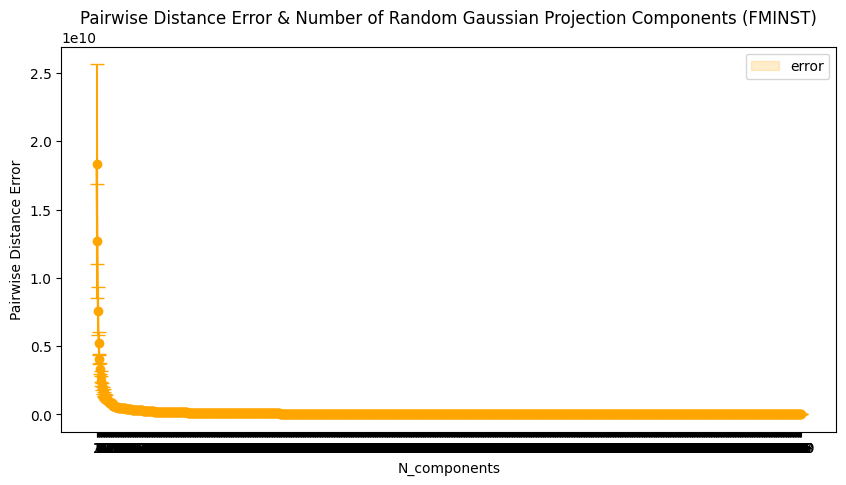

In [37]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Sample data and calculations
dataset=X_fm_scaled
rgp_size=range(1,1000)
repeats = 3
original_distance = scipy.spatial.distance.pdist(dataset)
reconstruction_error = np.zeros(len(rgp_size))
reconstruction_vals = np.zeros(shape=(len(rgp_size), repeats))
pairwise_distance_error = np.zeros(len(rgp_size))
pairwise_distance_errors= np.zeros(shape=(len(rgp_size), repeats))

for i_ind, i in tqdm(enumerate(rgp_size)):
    for ix, r in enumerate([21 * (1 + i) for i in range(repeats)]):
        rgp_comp = GaussianRandomProjection(n_components=i, random_state=r)
        rgp_comp.fit(dataset)

        dataset_transformed = rgp_comp.transform(dataset)
        dataset_reconstructed = rgp_comp.inverse_transform(dataset_transformed)
        error = mean_squared_error(dataset, dataset_reconstructed)
        reconstruction_error[i_ind] += error / 3
        reconstruction_vals[i_ind, ix] = error

        pairwise_distance_error[i_ind]+=((original_distance-scipy.spatial.distance.pdist(dataset_transformed))**2).sum()/3
        pairwise_distance_errors[i_ind, ix]=((original_distance-scipy.spatial.distance.pdist(dataset_transformed))**2).sum()

# Plotting reconstruction error with filled space between error bars
fig = plt.figure()
fig.set_size_inches(10, 5)

plt.title('Reconstruction Error & Number of Random Gaussian Projection Components (FMINST)')
plt.errorbar(rgp_size, reconstruction_error, yerr=np.std(reconstruction_vals, axis=1), fmt='o', capsize=5,color='orange')
plt.fill_between(rgp_size, reconstruction_error - np.std(reconstruction_vals, axis=1), reconstruction_error + np.std(reconstruction_vals, axis=1), alpha=0.2,color='orange',label='error')
plt.plot(rgp_size,reconstruction_error,color='orange')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.xticks(rgp_size);

# Plotting Pairwise Distance with filled space between error bars
fig = plt.figure()
fig.set_size_inches(10, 5)

plt.title('Pairwise Distance Error & Number of Random Gaussian Projection Components (FMINST)')
plt.errorbar(rgp_size, pairwise_distance_error, yerr=np.std(pairwise_distance_errors, axis=1), fmt='o', capsize=5,color='orange')
plt.fill_between(rgp_size, pairwise_distance_error - np.std(pairwise_distance_errors, axis=1), pairwise_distance_error + np.std(pairwise_distance_errors, axis=1), alpha=0.2, color='orange',label='error')
plt.plot(rgp_size,pairwise_distance_error, color='orange')
plt.xlabel('N_components')
plt.ylabel('Pairwise Distance Error')
plt.xticks(rgp_size);
plt.legend()

plt.show()

ValueError: operands could not be broadcast together with shapes (9,) (999,) 

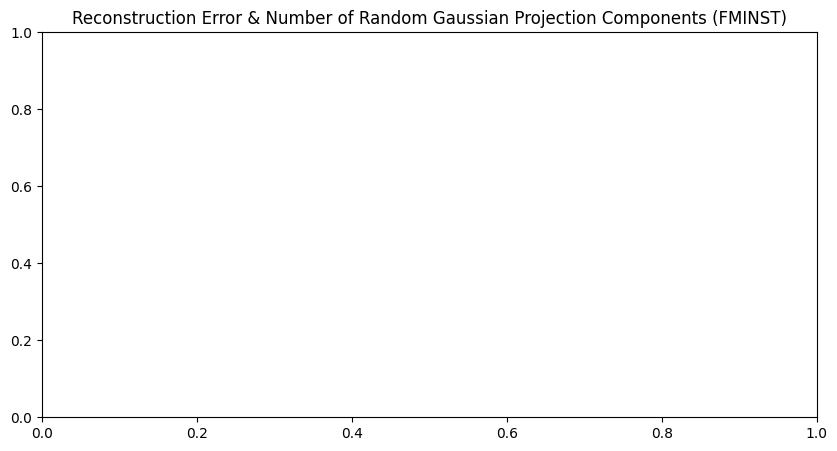

In [176]:
fig = plt.figure()
fig.set_size_inches(10, 5)

plt.title('Reconstruction Error & Number of Random Gaussian Projection Components (FMINST)')
#plt.errorbar(rgp_size, reconstruction_error, yerr=np.std(reconstruction_vals, axis=1), fmt='o', capsize=5, color='orange',alpha=0.5)
plt.fill_between(rgp_size, reconstruction_error - np.std(reconstruction_vals, axis=1), reconstruction_error + np.std(reconstruction_vals, axis=1), alpha=1,color='orange',label='error')
plt.plot(rgp_size,reconstruction_error,color='blue',linewidth=0.5)
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()
#plt.xticks(rgp_size);

# Plotting Pairwise Distance with filled space between error bars
fig = plt.figure()
fig.set_size_inches(10, 5)

plt.title('Pairwise Distance Error & Number of Random Gaussian Projection Components (FMINST)')
#plt.errorbar(rgp_size, pairwise_distance_error, yerr=np.std(pairwise_distance_errors, axis=1), fmt='o', capsize=5,color='orange',alpha=0.1)
plt.fill_between(rgp_size, pairwise_distance_error - np.std(pairwise_distance_errors, axis=1), pairwise_distance_error + np.std(pairwise_distance_errors, axis=1), alpha=1, color='orange',label='error')
plt.plot(rgp_size,pairwise_distance_error, color='blue',linewidth=0.5)
plt.xlabel('N_components')
plt.ylabel('Pairwise Distance Error')
#plt.xticks(rgp_size);
plt.legend()

plt.show()

In [94]:
np.argsort(np.std(reconstruction_vals, axis=1))[::-1]

array([149, 152, 151, 150, 145, 153, 146, 142, 147, 144, 141, 143, 154,
       556, 155, 140, 139, 148, 122, 564, 138, 160, 555, 158, 123, 128,
       157, 137, 512, 172, 159, 565, 121, 513, 551, 136, 171, 554, 170,
       161, 126, 156, 553, 108, 175, 162, 173, 563, 562, 164, 163, 127,
       124, 511, 165, 568, 550, 174, 119, 552, 125, 569, 118, 567, 382,
       510, 379, 176, 561, 131, 132, 120, 571, 509, 117, 514, 380, 492,
       129, 169, 584, 574, 566, 383, 381, 177, 559,  70, 491, 386, 572,
       130, 103, 506, 166, 384, 526, 579, 548, 168, 558, 167, 107, 501,
       573, 547, 549, 578, 508, 570, 557, 527, 507, 104, 580,  65, 134,
       560, 585, 385, 133, 586, 116,  68, 135, 515, 178, 577, 531,  66,
       486, 487, 525, 516, 494, 105, 583, 576, 628, 392,  64, 524, 495,
       587, 391, 493, 101,  72,  74, 106, 393,  71, 582, 500, 629,  69,
        67, 575, 588, 534, 581,  62, 523, 387, 490, 533, 394, 102, 378,
       377,  73, 488, 532, 436,  60, 433,  61,  48, 110, 520, 48

### Colinearity

In [115]:
#Applying PCA on the FMINST Dataset

#Remembering that the number of features for FMINST are 784
dataset=X_fm_scaled
big_pca=PCA(n_components=784,random_state=42)
big_pca.fit_transform(X_fm_scaled)

array([[ 1.04019369e+00,  2.14474133e+01, -1.44813495e+01, ...,
        -1.25151727e-01,  2.51748076e-02,  6.59357733e-14],
       [-7.37594481e+00, -1.31924114e+01, -8.65232730e-01, ...,
        -2.27962748e-03, -2.62391508e-02,  1.26182706e-16],
       [ 1.37937566e+01, -8.33501666e+00, -1.10244689e+01, ...,
         5.26703904e-02, -4.35537487e-02,  5.57025415e-17],
       ...,
       [-4.20864211e+00, -3.51592991e+00,  1.05525365e+01, ...,
         5.35952212e-02, -5.19790116e-02, -3.20718997e-16],
       [-1.97629884e+01, -8.60899841e-01,  6.06862359e+00, ...,
         2.97406919e-03, -6.59036211e-03,  3.38422613e-17],
       [ 5.55382917e+00,  4.56912158e+00,  3.44801833e+00, ...,
        -7.71700212e-02,  2.11449264e-02, -2.31193277e-16]])

In [147]:
sorted(np.abs(np.corrcoef(X_fm_scaled)[0]))[::-1]

[1.0,
 0.8369846491007167,
 0.8283169118585137,
 0.8142399695152007,
 0.8001132136755317,
 0.7991835617634012,
 0.7866507810192418,
 0.7848693361355055,
 0.7843115711625581,
 0.7837998014328094,
 0.7825168534149181,
 0.7801846310743848,
 0.7614900400875557,
 0.7610614373167712,
 0.7604537888637857,
 0.7563708788930863,
 0.754995111713877,
 0.7545154374810121,
 0.7533106199240053,
 0.7509679309826001,
 0.7490499886719351,
 0.7486456534570403,
 0.747114622908824,
 0.7468508879338129,
 0.7449902273670062,
 0.7425766366742773,
 0.7411977158932754,
 0.7384063821454195,
 0.7370602351061571,
 0.7359491261129637,
 0.734791742772064,
 0.7347744032377296,
 0.7314453007733162,
 0.7294989657563841,
 0.7283995681384966,
 0.7278548051872235,
 0.7271231190240394,
 0.7263133521761655,
 0.7242802214595916,
 0.7237795414351855,
 0.7225882286195613,
 0.7223611418999585,
 0.7200449873417007,
 0.7197441915736285,
 0.7197317583406447,
 0.7187907938738921,
 0.7182479951617389,
 0.716914817681363,
 0.71675736

In [164]:
sorted(np.abs(pd.DataFrame(X_fm_scaled).corr().iloc[1]))[::-1]

[1.0,
 0.9861934242513536,
 0.827762925521633,
 0.6701315351170294,
 0.6310166520953129,
 0.617767052646868,
 0.607209241835703,
 0.5961302172367583,
 0.40809436318172587,
 0.3946739183256812,
 0.38633202057169824,
 0.3788522878881251,
 0.3330021613717971,
 0.32957503050080966,
 0.3035074409110173,
 0.301836087836754,
 0.2799429789137683,
 0.2762729937576893,
 0.25726144603037776,
 0.24232160006479966,
 0.2314497820650528,
 0.2064574402720417,
 0.20635252272968843,
 0.19571652980831883,
 0.19416028563857263,
 0.19317342990434871,
 0.1762447343052108,
 0.1712125298671154,
 0.1645326959988894,
 0.16445800212071962,
 0.1581055219104335,
 0.15599000389573084,
 0.15535660173793547,
 0.15286397764047605,
 0.14484117666110757,
 0.14217285282348557,
 0.14200354749704505,
 0.13933232421812403,
 0.1376099588363089,
 0.12875157381905314,
 0.12740472242544557,
 0.12529153117270092,
 0.12363299179798076,
 0.11513500791658743,
 0.11337116440899062,
 0.11318615591331357,
 0.10562752866190753,
 0.1046

In [160]:
sorted(np.abs(pd.DataFrame(X_heart_scaled).corr().iloc[0]))[::-1]

[1.0,
 0.3820446750319702,
 0.25861153601875625,
 0.2580671944033565,
 0.25439935615154474,
 0.23056574637513325,
 0.21816541113297,
 0.21579269076374738,
 0.21579269076374732,
 0.1980390658667436,
 0.19803906586674358,
 0.18556774640881782,
 0.16660682970666252,
 0.14572733567992263,
 0.13839701363862994,
 0.1367984232907623,
 0.09528177118121897,
 0.05575009917778455,
 0.05575009917778455,
 0.03204165141190095,
 0.0113349271826481]

In [138]:
sorted(np.abs(np.cov(X_fm_scaled).flatten()))[::-1]

[53.951317550876254,
 20.486317846411765,
 16.804915654634076,
 16.540057456691308,
 12.027300116669673,
 10.785652776966602,
 10.785652776966602,
 10.14371621203929,
 9.796224033066629,
 9.674947234072594,
 9.466231328598209,
 9.466231328598209,
 8.810103698228284,
 8.801285534021405,
 8.707009677816469,
 8.707009677816469,
 8.573334145771828,
 8.5023421409102,
 8.502068450530096,
 8.122055398002415,
 8.122055398002415,
 7.59850458828796,
 7.552052813628693,
 7.552052813628693,
 7.398288317032587,
 7.299101103873032,
 7.299101103873032,
 7.204841368125156,
 7.204841368125156,
 7.168655322046228,
 7.0142962790379695,
 7.0142962790379695,
 6.871757000882656,
 6.85359419350931,
 6.838797476712717,
 6.838797476712717,
 6.832859784448341,
 6.735981463599418,
 6.7105321744944675,
 6.7105321744944675,
 6.707537513213179,
 6.68673792196644,
 6.68673792196644,
 6.644686017647717,
 6.644686017647717,
 6.508364064571458,
 6.508364064571458,
 6.490335437689001,
 6.490335437689001,
 6.387354624189

In [139]:
sorted(np.abs(np.cov(X_heart_scaled).flatten()))[::-1]

[3.147810093185244,
 2.8992028174640936,
 2.798810664599776,
 2.72326365299404,
 2.6292878943684017,
 2.547197452289547,
 2.525258355720009,
 2.5155339000371484,
 2.35738931453049,
 2.3026787302389535,
 2.265596833840828,
 2.2574164574032483,
 2.247862079890814,
 2.247862079890814,
 2.2194632872784603,
 2.20598929231902,
 2.2044058468218672,
 2.1901469196907253,
 2.1901469196907253,
 2.1808387403096474,
 2.1696418114937672,
 2.1624333617900304,
 2.1624333617900304,
 2.161264460684069,
 2.1477430991575086,
 2.1477430991575086,
 2.1392096815084725,
 2.1047352088775413,
 2.0905548161639795,
 2.0905548161639795,
 2.0855975521519543,
 2.079563300776266,
 2.079563300776266,
 2.069087669817578,
 2.053833659236639,
 2.0328082650741766,
 1.9905651654115308,
 1.9611514134343477,
 1.9563864566536957,
 1.9514235359686272,
 1.945987604219441,
 1.9348466853087978,
 1.9287244058907935,
 1.9248231510108398,
 1.9142700854944963,
 1.9142700854944963,
 1.9112945714492122,
 1.9058308415016851,
 1.89367665

## ICA TESTING

In [168]:
#Correlated
np.random.seed(0)
n_samples = 1000
mean = np.zeros(10)
covariance = np.array([[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
                       [0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2],
                       [0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
                       [0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4],
                       [0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                       [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6],
                       [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7],
                       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8],
                       [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9],
                       [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]])

hc_data = np.random.multivariate_normal(mean, covariance, size=n_samples)
sclr=StandardScaler()
hc_data_scaled=sclr.fit_transform(hc_data)

In [169]:
# Generate independent data
np.random.seed(0)
n_samples = 1000
n_features = 10

uc_data = np.random.rand(n_samples, n_features)
sclr=StandardScaler()
uc_data_scaled=sclr.fit_transform(uc_data)

The lowest number of components to exceed the limit of 0.85 is 2


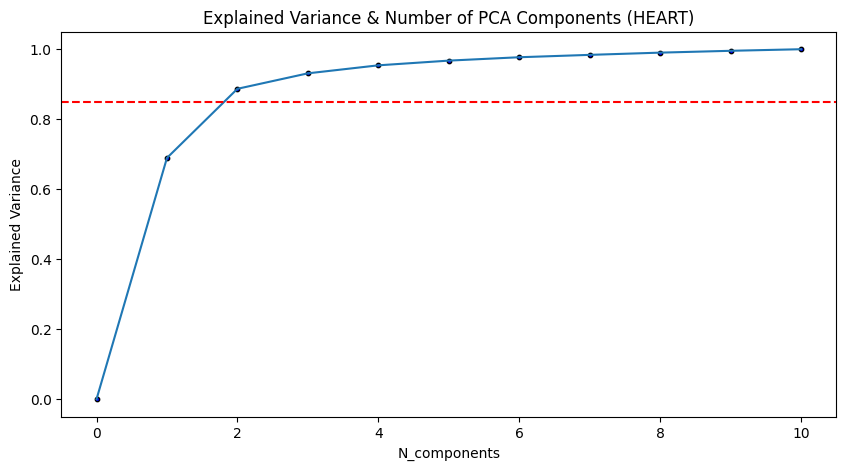

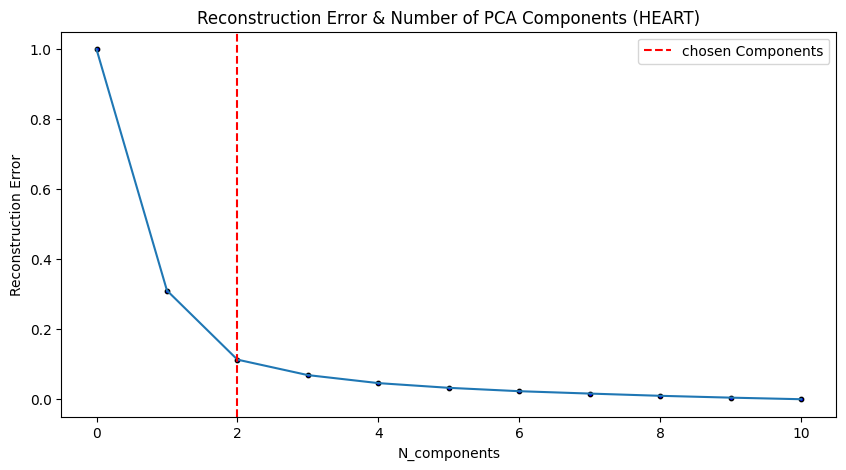

In [171]:
#ICA
#Applying PCA on the FMINST Dataset

#Remembering that the number of features for FMINST are 784
dataset=hc_data_scaled
chosen_n_pca_d2=None

pca_size=range(11)
repeats=3
ideal_comps=None 
LIMIT=0.85

explained_variance=np.zeros(len(pca_size))
reconstruction_error=np.zeros(len(pca_size))

for r in [21*(1+i) for i in range(repeats)]:

    for i_ind,i in enumerate(pca_size):
        p_comp=PCA(n_components=i,random_state=r)
        p_comp.fit(dataset)
        explained_variance[i_ind]+=sum(p_comp.explained_variance_ratio_)/repeats

        #Calcualting Reconstruction Error
        dataset_transformed=p_comp.transform(dataset)
        dataset_reconstructed=p_comp.inverse_transform(dataset_transformed)
        reconstruction_error[i_ind]+=mean_squared_error(dataset,dataset_reconstructed)/repeats

#Plotting explained variance 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Explained Variance & Number of PCA Components (HEART)')
plt.plot(pca_size,explained_variance)
plt.scatter(pca_size, explained_variance, s=10, c='blue', marker='o', edgecolors='black')
plt.axhline(y=LIMIT,color='red',linestyle='--')
plt.xlabel('N_components')
plt.ylabel('Explained Variance')

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of PCA Components (HEART)')
plt.plot(pca_size,reconstruction_error)
plt.scatter(pca_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.axvline(np.argwhere(explained_variance>LIMIT)[0][0],color='red',linestyle='--',label=f'chosen Components')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()

print('The lowest number of components to exceed the limit of {} is {}'.format(LIMIT,np.argwhere(explained_variance>LIMIT)[0][0]))
chosen_n_pca_d2=np.argwhere(explained_variance>LIMIT)[0][0]

The lowest number of components to exceed the limit of 0.85 is 9


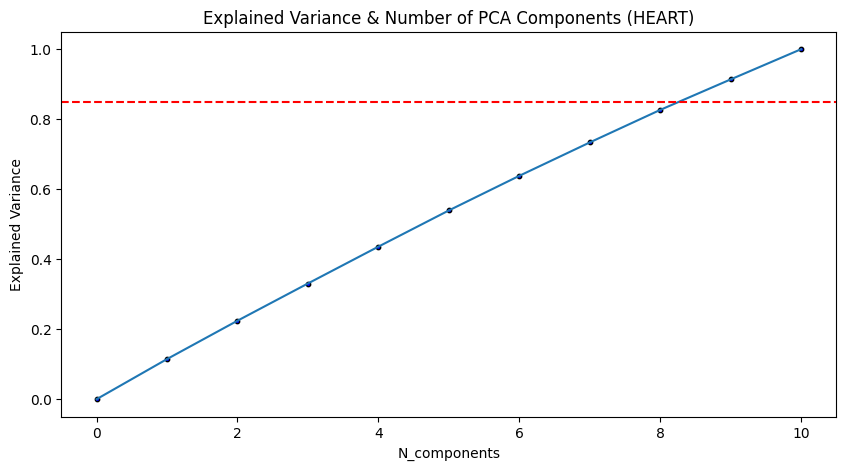

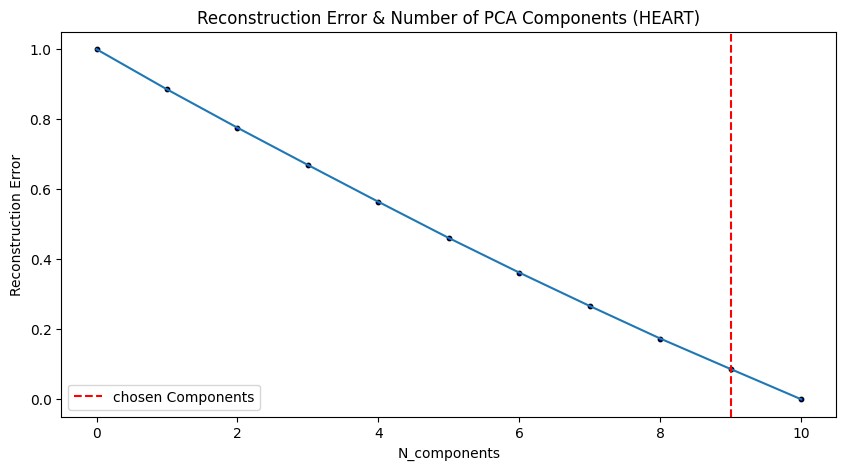

In [172]:
#ICA
#Applying PCA on the FMINST Dataset

#Remembering that the number of features for FMINST are 784
dataset=uc_data_scaled
chosen_n_pca_d2=None

pca_size=range(11)
repeats=3
ideal_comps=None 
LIMIT=0.85

explained_variance=np.zeros(len(pca_size))
reconstruction_error=np.zeros(len(pca_size))

for r in [21*(1+i) for i in range(repeats)]:

    for i_ind,i in enumerate(pca_size):
        p_comp=PCA(n_components=i,random_state=r)
        p_comp.fit(dataset)
        explained_variance[i_ind]+=sum(p_comp.explained_variance_ratio_)/repeats

        #Calcualting Reconstruction Error
        dataset_transformed=p_comp.transform(dataset)
        dataset_reconstructed=p_comp.inverse_transform(dataset_transformed)
        reconstruction_error[i_ind]+=mean_squared_error(dataset,dataset_reconstructed)/repeats

#Plotting explained variance 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Explained Variance & Number of PCA Components (HEART)')
plt.plot(pca_size,explained_variance)
plt.scatter(pca_size, explained_variance, s=10, c='blue', marker='o', edgecolors='black')
plt.axhline(y=LIMIT,color='red',linestyle='--')
plt.xlabel('N_components')
plt.ylabel('Explained Variance')

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of PCA Components (HEART)')
plt.plot(pca_size,reconstruction_error)
plt.scatter(pca_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.axvline(np.argwhere(explained_variance>LIMIT)[0][0],color='red',linestyle='--',label=f'chosen Components')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()

print('The lowest number of components to exceed the limit of {} is {}'.format(LIMIT,np.argwhere(explained_variance>LIMIT)[0][0]))
chosen_n_pca_d2=np.argwhere(explained_variance>LIMIT)[0][0]

9it [00:01,  5.18it/s]


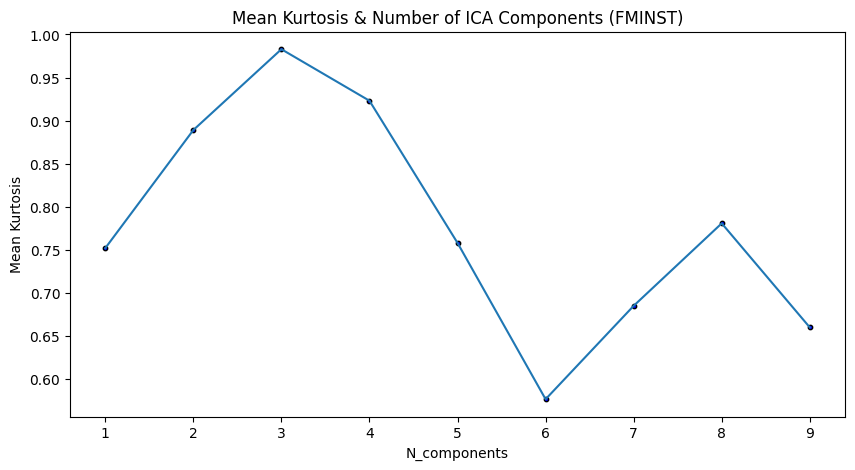

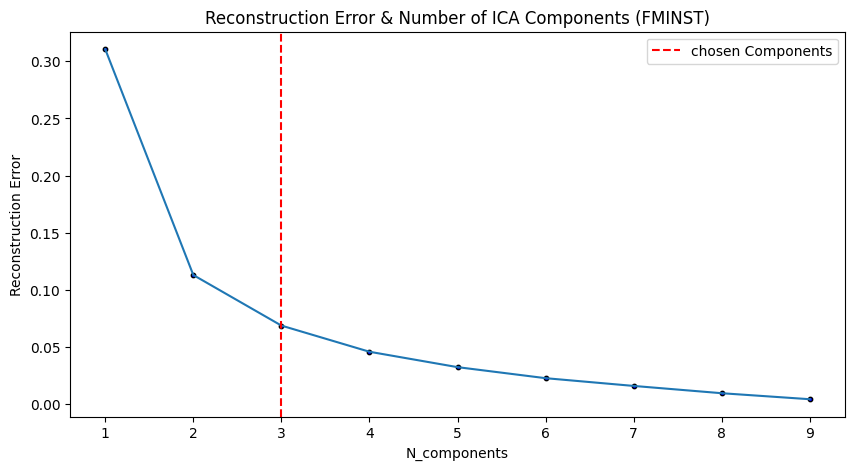

In [173]:
#Applying ICA on the FMINST Dataset

#Remembering that the number of features for FMINST are 784
dataset=hc_data_scaled
chosen_n_ica_d1=None

ica_size=range(1,10)
repeats=3
ideal_comps=None 

kurtosis=np.zeros(len(ica_size))
reconstruction_error=np.zeros(len(ica_size))

for i_ind,i in tqdm(enumerate(ica_size)):
    for r in [21*(1+i) for i in range(repeats)]:
        ica_comp=FastICA(n_components=i,random_state=r,max_iter=500)
        ica_comp.fit(dataset)
        kurtosis[i_ind]+=scipy.stats.kurtosis(np.abs(ica_comp.transform(dataset))).mean()/repeats

        #Getting error
        dataset_transformed=ica_comp.transform(dataset)
        dataset_reconstructed=ica_comp.inverse_transform(dataset_transformed)
        error=mean_squared_error(dataset,dataset_reconstructed)
        reconstruction_error[i_ind]+=error/3

#Plotting explained variance 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Mean Kurtosis & Number of ICA Components (FMINST)')
plt.plot(ica_size,kurtosis)
plt.scatter(ica_size, kurtosis, s=10, c='blue', marker='o', edgecolors='black')
plt.xlabel('N_components')
plt.ylabel('Mean Kurtosis')

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of ICA Components (FMINST)')
plt.plot(ica_size,reconstruction_error)
plt.scatter(ica_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.axvline(ica_size[np.argmax(kurtosis)],color='red',linestyle='--',label=f'chosen Components')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()

9it [00:00, 90.89it/s]


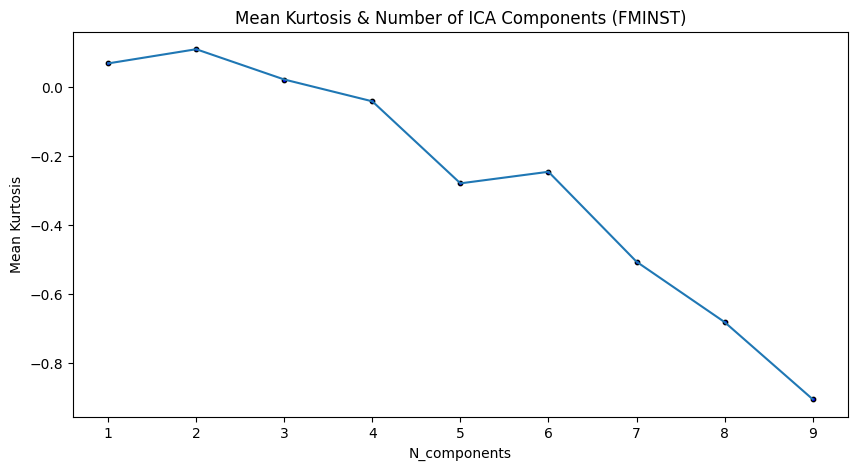

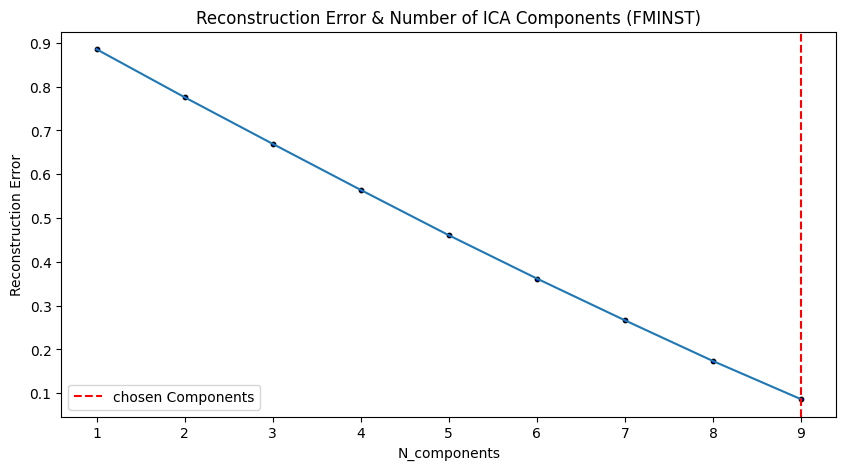

In [175]:
#Applying ICA on the FMINST Dataset

#Remembering that the number of features for FMINST are 784
dataset=uc_data_scaled
chosen_n_ica_d1=None

ica_size=range(1,10)
repeats=3
ideal_comps=None 

kurtosis=np.zeros(len(ica_size))
reconstruction_error=np.zeros(len(ica_size))

for i_ind,i in tqdm(enumerate(ica_size)):
    for r in [21*(1+i) for i in range(repeats)]:
        ica_comp=FastICA(n_components=i,random_state=r,max_iter=500)
        ica_comp.fit(dataset)
        kurtosis[i_ind]+=scipy.stats.kurtosis(np.abs(ica_comp.transform(dataset))).mean()/repeats

        #Getting error
        dataset_transformed=ica_comp.transform(dataset)
        dataset_reconstructed=ica_comp.inverse_transform(dataset_transformed)
        error=mean_squared_error(dataset,dataset_reconstructed)
        reconstruction_error[i_ind]+=error/3

#Plotting explained variance 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Mean Kurtosis & Number of ICA Components (FMINST)')
plt.plot(ica_size,kurtosis)
plt.scatter(ica_size, kurtosis, s=10, c='blue', marker='o', edgecolors='black')
plt.xlabel('N_components')
plt.ylabel('Mean Kurtosis')

#Plotting reconstruction error 
fig=plt.figure()
fig.set_size_inches(10,5)

plt.title('Reconstruction Error & Number of ICA Components (FMINST)')
plt.plot(ica_size,reconstruction_error)
plt.scatter(ica_size, reconstruction_error, s=10, c='blue', marker='o', edgecolors='black')
plt.axvline(ica_size[np.argmax(np.abs(kurtosis))],color='red',linestyle='--',label=f'chosen Components')
plt.xlabel('N_components')
plt.ylabel('Reconstruction Error')
plt.legend()